To determine if I am successful, lets say we want less than a 5% error rate, then ch

In [1]:
0.95**20

0.3584859224085419

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np

This is not as well documented as I would like, but the basic jist of it is this

1. we have the datasets, not all have been incorporated, but first
    a) total: raw data from Line_Data.csv, as well as the angle of the main axis line The columns are as follows:
        i) filename: the filename of that row
        ii) framenumber: The frame of the video this row came from
        iii) Size: The number of masked pixels in the frame
        iv) Volume: The estimated volume using the method of disks
        v) x1: The x coordinate of one end of the central axis
        vi) y1: The y coordinate of one end of the central axis
        vii) x2: The x coordinate of one end of the central axis
        vii) y2: The y coordinate of one end of the central axis
        ix) length: The length of the central axis
        x) Problem: The issue with the frame, NaN if none
        xi) The angle of the central axis
    b) grouped: the number of non-zero entries for each video. For all columns but "Problem" This is simply the number of frames in the video, in "Problem" it is the number of frames I could not produce the correct line of the csv for
    c) med_grouped: The median value of each numerical column for each video
    d) mean_grouped: the mean value of each numerical column for each video
    e) range_grouped: the range of each numerical column for each video
    f) std_grouped: the standard deviation of each numerical column for each video
2. We have calculated values:
    a) Moving average std for size and volume: this is the standard deviation of a 32 frame moving average, they are labeled std_S and std_V
    B) top two values of the fourier transform: This is the maximum and second maximum values of the fft(volume), not the frequencies. this is labeled fft1_V and fft2_V
    C) top two values of the fourier transform: This is the maximum and second maximum values of the fft(Size), not the frequencies. this is labeled fft1_S and fft2_S
3. We have analyses, they will be explained for each one at the calculation

In [3]:
total = pd.read_csv("C:\\Users\\TheurerJ\\Documents\\Data\\Line_Data.csv")
total['Degrees'] = np.degrees(np.arctan2(total['y2'].to_numpy()-total['y1'].to_numpy(),total['x2'].to_numpy()-total['x1'].to_numpy()))
grouped = total.groupby("Filename",sort = False).count()
med_grouped = total.groupby("Filename").median()
std_grouped = total.groupby("Filename").std()
mean_grouped = total.groupby("Filename").mean()
range_grouped = total.groupby("Filename")[['Size','Volume','x1','y1','x2','y2','length','Degrees']].quantile(0.9)-total.groupby("Filename")[['Size','Volume','x1','y1','x2','y2','length','Degrees']].quantile(0.1)
inital_mask = (grouped["Size"]>32) & (grouped["Problem"]==0)
mask2 = (std_grouped['Volume']>0) & (std_grouped['Size']>0) & (std_grouped['x1']>0) & (std_grouped['y1']>0) & (std_grouped['x2']>0) & (std_grouped['y2']>0) & (std_grouped['length']>0) & (std_grouped['Degrees']>0)
inital_mask = inital_mask & mask2

In [141]:
total.head()

,Filename,frame number,Size,Volume,x1,y1,x2,y2,length,Problem,Degrees
0,1AFJUFVQ.avi,0,490,4719.669481,64,55,55,26,30.364453,NaN,-107.241459
1,1AFJUFVQ.avi,1,488,4675.379994,64,55,55,26,30.364453,NaN,-107.241459
2,1AFJUFVQ.avi,2,489,4455.994228,64,55,54,26,30.675723,NaN,-109.025606
3,1AFJUFVQ.avi,3,489,4294.944653,64,55,55,26,30.364453,NaN,-107.241459
4,1AFJUFVQ.avi,4,482,4335.963254,65,55,53,26,31.384710,NaN,-112.479434


In [4]:
sum(mask2)

108408

In [5]:
total[total['Size']==0]['Problem']

276         Size or points
304         Size or points
324         Size or points
327         Size or points
328         Size or points
                 ...      
18060764    Size or points
18060774    Size or points
18060775    Size or points
18060824    Size or points
18060825    Size or points
Name: Problem, Length: 6398, dtype: object

In [6]:
index = []
for i in tqdm(grouped['Volume']):
    try:
        add = index[-1]
    except:
        print("once")
        add = 0
    index.append(add+i)
grouped["index"]=index

100%|█████████████████████████████████████████████████████████████████████| 108450/108450 [00:00<00:00, 2173022.44it/s]

once


In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
vol = total.Volume.to_numpy()
stds = []
ffts = []
fft2s = []
loc = grouped.index[0]

if inital_mask[loc]:
    start = grouped['index'][grouped.index[0]]
    stds.append(np.std(moving_average(vol[:start],32)))
    ffts.append(np.fft.fft(vol[:start])[0])
    fft2s.append(max(np.fft.fft(vol[:start])[1:]))
else:
    stds.append(None)
    ffts.append(None)
    fft2s.append(None)

for i in tqdm(range(1,len(grouped.index))):
    loc = grouped.index[i]
    if inital_mask[loc]:
        start = grouped['index'][grouped.index[i-1]]
        end = grouped['index'][grouped.index[i]]-1
        stds.append(np.std(moving_average(vol[start:end],32)))
        ffts.append(np.fft.fft(vol[start:end])[0])
        fft2s.append(max(np.fft.fft(vol[start:end])[1:]))
    else:
        stds.append(None)
        ffts.append(None)
        fft2s.append(None)
grouped['std_V']=stds
grouped['fft1_V']=ffts
mean_grouped['std_V']=stds
mean_grouped['fft1_V']=ffts
std_grouped['std_V']=stds
std_grouped['fft1_V']=ffts
range_grouped['std_V']=stds
range_grouped['fft1_V']=ffts
grouped['fft2_V']=ffts
mean_grouped['fft2_V']=ffts
std_grouped['fft2_V']=ffts
range_grouped['fft2_V']=ffts

vol = total.Size.to_numpy()
stds = []
ffts = []
fft2s = []
loc = grouped.index[0]

if inital_mask[loc]:
    start = grouped['index'][grouped.index[0]]
    stds.append(np.std(moving_average(vol[:start],32)))
    ffts.append(np.fft.fft(vol[:start])[0])
    fft2s.append(max(np.fft.fft(vol[:start])[1:]))
else:
    stds.append(None)
    ffts.append(None)
    fft2s.append(None)

for i in tqdm(range(1,len(grouped.index))):
    loc = grouped.index[i]
    if inital_mask[loc]:
        start = grouped['index'][grouped.index[i-1]]
        end = grouped['index'][grouped.index[i]]-1
        stds.append(np.std(moving_average(vol[start:end],32)))
        ffts.append(np.fft.fft(vol[start:end])[0])
        fft2s.append(max(np.fft.fft(vol[start:end])[1:]))
    else:
        stds.append(None)
        ffts.append(None)
        fft2s.append(None)
grouped['std_S']=stds
grouped['fft1_S']=ffts
mean_grouped['std_S']=stds
mean_grouped['fft1_S']=ffts
std_grouped['std_S']=stds
std_grouped['fft1_S']=ffts
range_grouped['std_S']=stds
range_grouped['fft1_S']=ffts
grouped['fft2_S']=ffts
mean_grouped['fft2_S']=ffts
std_grouped['fft2_S']=ffts
range_grouped['fft2_S']=ffts

100%|████████████████████████████████████████████████████████████████████████| 108449/108449 [00:11<00:00, 9173.65it/s]


In [8]:
grouped.head()

,frame number,Size,Volume,x1,y1,x2,y2,length,Problem,Degrees,index,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S
Filename,,,,,,,,,,,,,,,,,
1AFJUFVQ.avi,118,118,118,118,118,118,118,118,0,118,118,257.390723,4.429080e+05+0.000000e+00j,4.429080e+05+0.000000e+00j,18.596948,51482.000000+0.000000j,51482.000000+0.000000j
1AG1LTSE.avi,134,134,134,134,134,134,134,134,0,134,252,1796.560513,2.024082e+06+0.000000e+00j,2.024082e+06+0.000000e+00j,105.770835,143031.000000+0.000000j,143031.000000+0.000000j
1AG6EOVQ.avi,142,142,142,142,142,142,142,142,42,142,394,NaN,NaN,NaN,NaN,NaN,NaN
1AGCWGMH.avi,169,169,169,169,169,169,169,169,0,169,563,652.795155,1.504544e+06+0.000000e+00j,1.504544e+06+0.000000e+00j,26.477651,124047.000000+0.000000j,124047.000000+0.000000j
1AGV8XHL.avi,246,246,246,246,246,246,246,246,49,246,809,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


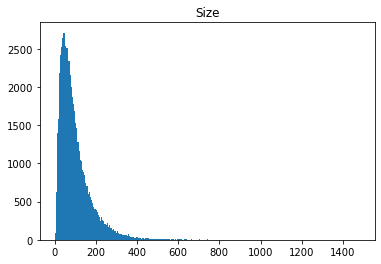

[ 0.          2.96003634  5.92007268  8.88010902 11.84014535 14.80018169
 17.76021803 20.72025437 23.68029071 26.64032705 29.60036339 32.56039972
 35.52043606 38.4804724  41.44050874 44.40054508 47.36058142 50.32061776
 53.28065409 56.24069043]


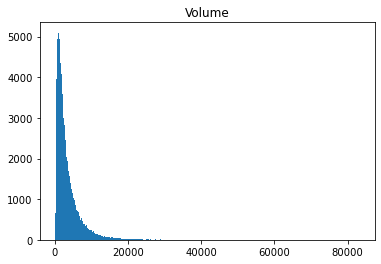

[   0.          166.36123456  332.72246913  499.08370369  665.44493825
  831.80617281  998.16740738 1164.52864194 1330.8898765  1497.25111106
 1663.61234563 1829.97358019 1996.33481475 2162.69604931 2329.05728388
 2495.41851844 2661.779753   2828.14098757 2994.50222213 3160.86345669]


In [9]:
import matplotlib.pyplot as plt
height = plt.hist(grouped['std_S'],bins=500)
plt.title("Size")
plt.show()
print(height[1][:20])
height = plt.hist(grouped['std_V'],bins=500)
plt.title("Volume")
plt.show()
print(height[1][:20])

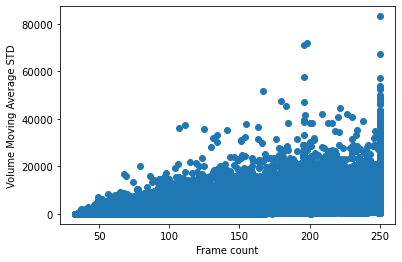

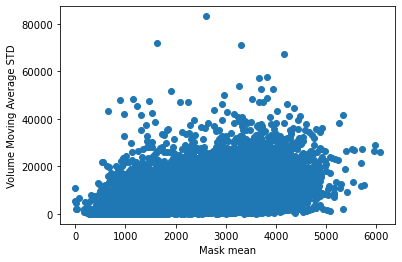

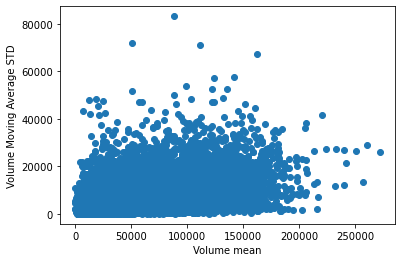

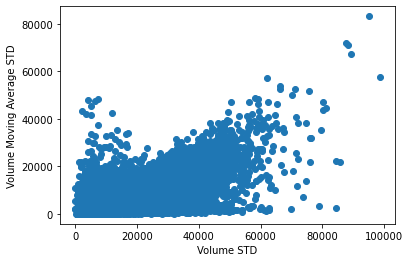

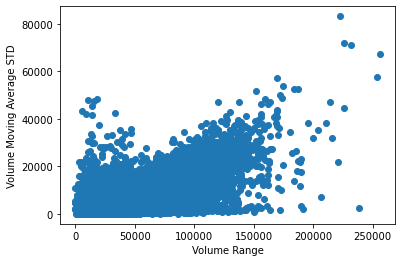

In [10]:
plt.scatter(grouped['Size'],grouped['std_V'])
plt.xlabel("Frame count")
plt.ylabel("Volume Moving Average STD")
plt.show()
plt.scatter(mean_grouped['Size'],mean_grouped['std_V'])
plt.xlabel("Mask mean")
plt.ylabel("Volume Moving Average STD")
plt.show()
plt.scatter(mean_grouped['Volume'],mean_grouped['std_V'])
plt.xlabel("Volume mean")
plt.ylabel("Volume Moving Average STD")
plt.show()
plt.scatter(std_grouped['Volume'],mean_grouped['std_V'])
plt.xlabel("Volume STD")
plt.ylabel("Volume Moving Average STD")
plt.show()
plt.scatter(range_grouped['Volume'],mean_grouped['std_V'])
plt.xlabel("Volume Range")
plt.ylabel("Volume Moving Average STD")
plt.show()

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


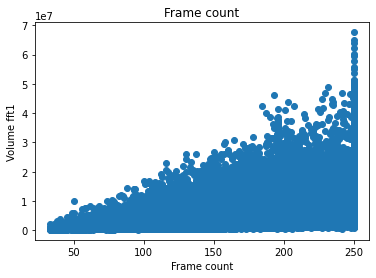

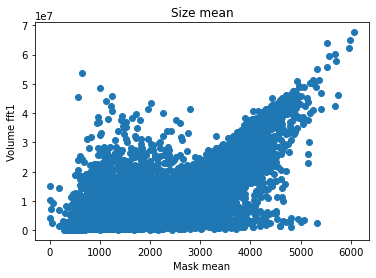

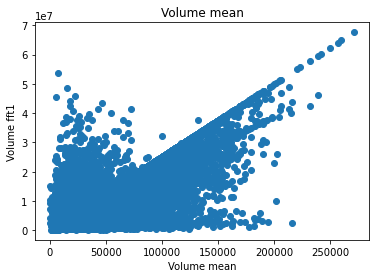

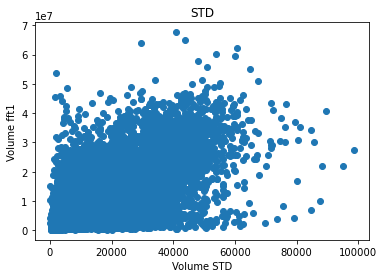

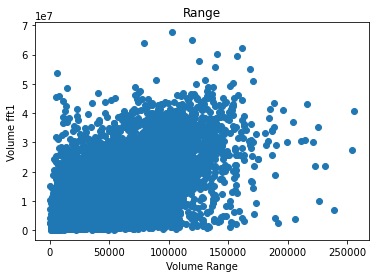

In [11]:
plt.scatter(grouped['Size'],grouped['fft1_V'])
plt.xlabel("Frame count")
plt.title("Frame count")
plt.ylabel("Volume fft1")
plt.show()
plt.scatter(mean_grouped['Size'],mean_grouped['fft1_V'])
plt.title("Size mean")
plt.xlabel("Mask mean")
plt.ylabel("Volume fft1")
plt.show()
plt.scatter(mean_grouped['Volume'],mean_grouped['fft1_V'])
plt.title("Volume mean")
plt.xlabel("Volume mean")
plt.ylabel("Volume fft1")
plt.show()
plt.scatter(std_grouped['Volume'],mean_grouped['fft1_V'])
plt.title("STD")
plt.xlabel("Volume STD")
plt.ylabel("Volume fft1")
plt.show()
plt.scatter(range_grouped['Volume'],mean_grouped['fft1_V'])
plt.title("Range")
plt.xlabel("Volume Range")
plt.ylabel("Volume fft1")
plt.show()

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 8.000e+00, 7.600e+01,
        1.100e+01, 1.300e+01, 9.000e+00, 7.000e+00, 1.000e+01, 1.900e+01,
        2.800e+01, 1.600e+01, 1.800e+01, 1.800e+01, 8.000e+00, 1.600e+01,
        1.400e+01, 1.400e+01, 1.100e+01, 1.000e+01, 1.000e+01, 2.500e+01,
        1.400e+01, 1.100e+01, 1.100e+01, 2.000e+01, 4.900e+01, 2.600e+01,
        4.200e+01, 6.500e+01, 3.500e+01, 3.800e+01, 3.500e+01, 4.400e+01,
        3.900e+01, 6.100e+01, 3.900e+01, 5.700e+01, 6.100e+01, 8.200e+01,
        1.070e+02, 8.200e+01, 7.100e+01, 7.700e+01, 7.500e+01, 1.040e+02,
        1.030e+02, 1.010e+02, 9.700e+01, 1.010e+02, 1.220e+02, 9.900e+01,
        9.700e+01, 9.700e+01, 1.060e+02, 9.100e+01, 1.040e+02, 1.110e+02,
        1.280e+02, 1.060e+02, 1.010e+02, 2.200e+02, 1.280e+02, 1.200e+02,
        1.490e+02, 1.420e+02, 1.600e+02, 1.670e+02, 1.550e+02, 1.530e+02,
        1.800e+02, 1.650e+02, 1.780e+0

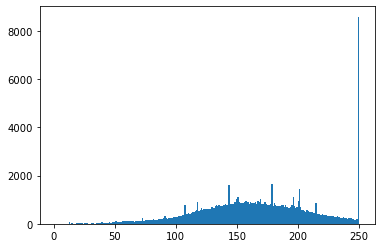

In [12]:
plt.hist(grouped['frame number'],bins = len(grouped['Size'].unique()))

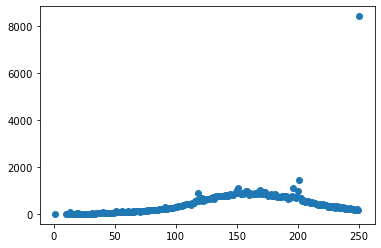

In [13]:
sizes = []
ordered_sizes = np.sort(grouped['Size'].unique())
for i in ordered_sizes:
    sizes.append(len(grouped[grouped.Size==i]))
plt.scatter(ordered_sizes,sizes)

In [14]:
def eliminate_outlier(df,o=False):
    low = df.quantile(.25)
    high = df.quantile(.75)
    
    iqr = 1.5*(high-low)
    low = low - iqr
    high = high+iqr
    if o:
        print(low,high)
    
    mask = (df>low) & (df < high)
    return mask
temp = grouped[inital_mask]
identified = pd.Series()
for i in tqdm(ordered_sizes[:]):
    if i ==148 or i == 160:
        eliminate_outlier(temp[temp.Size==i]['std_V'],o=True)
    identified=identified.append(eliminate_outlier(temp[temp.Size==i]['std_V']))

<ipython-input-14-bbc2214b9b41>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = grouped[inital_mask]
<ipython-input-14-bbc2214b9b41>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  identified = pd.Series()
 73%|█████████████████████████████████████████████████████████▍                     | 176/242 [00:00<00:00, 411.77it/s]

-1892.752005923403 5655.477780118534
-2806.815986059185 7573.288206418382


100%|███████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 363.24it/s]


In [15]:
sum(identified)/len(identified)

0.9456060648814395

In [16]:
identified[identified]

2N5WU8K6.avi    True
3VPGHS12.avi    True
57YMNSDR.avi    True
5DG3HZ25.avi    True
AD3IF93V.avi    True
                ... 
FP3ST9SP.avi    True
FP3SU5DC.avi    True
FP3T2AFD.avi    True
FP3T2FAQ.avi    True
FPLBUGZH.avi    True
Length: 100534, dtype: bool

In [17]:
np.random.choice(identified[identified].index,10)

array(['AC6R9G5E.avi', '1LYMDRUB.avi', '44WPJV1C.avi', '7PIQTK3T.avi',
       'D3V1YWDC.avi', '4409OD85.avi', '564Z168C.avi', '2WTJHLQ8.avi',
       '564N2UCW.avi', '2S7TUNXZ.avi'], dtype=object)

In [18]:
sum(identified)

100534

In [19]:

secondary_mask = identified & inital_mask

In [20]:
sum(secondary_mask)/len(secondary_mask)

0.9270078377132319

In [21]:
print("bad",grouped['std_V']['1AX2UAPB.avi'],secondary_mask['1AX2UAPB.avi'])
print("good",grouped['std_V']['1AGCWGMH.avi'],secondary_mask['1AGCWGMH.avi'])
print("bad",grouped['std_V']['1AXEKIJO.avi'],secondary_mask['1AXEKIJO.avi'])
print("good",grouped['std_V']['5B6DUZ22.avi'],secondary_mask['5B6DUZ22.avi'])

bad 1197.1940282598837 True
good 652.7951548095256 True
bad 13246.393045960558 False
good 266.3453240066114 True


In [22]:
print("Frame Count")
data = grouped[grouped.Size<250].index.unique()
size_mask = inital_mask & (grouped.Size==250)
print(len(data)*100/len(grouped.index),'%',"New eliminations:",sum(inital_mask)-sum(size_mask))
print("Videos to check",np.random.choice(data,5))

Frame Count
92.24711848778239 % New eliminations: 98168
Videos to check ['D5P77PMZ.avi' 'BRMDABHQ.avi' '6FM94V50.avi' 'E97MBSI3.avi'
 '571VLS8H.avi']


# Volume MA STD by Frame

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually STD_V for the number of frames they have.

<ipython-input-23-77add6eb40b8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = grouped[inital_mask]
100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1565.13it/s]


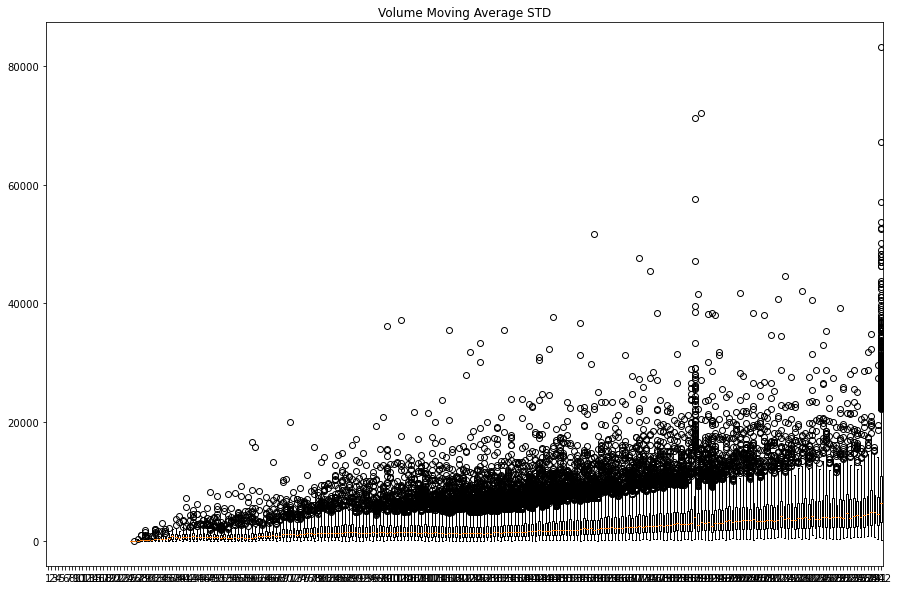

In [23]:
box_plot_data = []
temp = grouped[inital_mask]
for i in tqdm(ordered_sizes[:]):
    box_plot_data.append(temp[temp.Size==i]['std_V'].to_numpy())
plt.figure(figsize=(15,10))
plt.boxplot(box_plot_data)
plt.title("Volume Moving Average STD")
plt.show()

In [24]:
def List_outlier(df):
    low = df.quantile(.25)
    high = df.quantile(.75)
    iqr = 1.5*(high-low)
    low = low - iqr
    high = high+iqr
    df = df[(df<low) | (df > high)]
    return df.index

In [25]:
List_outlier(grouped[grouped.Size==250]['std_V'])

Index(['1AX2JAF6.avi', '1BDG0A6F.avi', '1BDM7U2K.avi', '1BTZQKH8.avi',
       '1DOB2QEY.avi', '1E4U75AC.avi', '1E4UK1KK.avi', '1E5645UT.avi',
       '1EM1EHM4.avi', '1EM7DB7G.avi',
       ...
       'FC9EG41C.avi', 'FE2VQ0J0.avi', 'FFGHUTSC.avi', 'FHANF116.avi',
       'FHR6PU3V.avi', 'FIO9IVXB.avi', 'FK1VP43K.avi', 'FK1VVS3U.avi',
       'FO6Q8YET.avi', 'FONX5EQL.avi'],
      dtype='object', name='Filename', length=360)

Examination of identified bad at length = 250

1AX2JAF6.avi bad
1BDG0A6F.avi bad
1BDM7U2K.avi bad
1BTZQKH8.avi bad
1DOB2QEY.avi bad

but 1AX2WIYU.avi is included and looks bad

In [26]:
List_outlier(grouped[grouped.Size==100]['std_V'])

Index(['1HS5F9XG.avi', '3YHT6IDM.avi', '40B5WMZ5.avi', '431EMHBP.avi',
       '43289XQE.avi', '469HX6JX.avi', 'AAC9YWD6.avi', 'BJCOVNRU.avi',
       'BL6CMUYX.avi', 'BNHOZRFW.avi', 'BUUB6R0Q.avi', 'BV9V0PKP.avi'],
      dtype='object', name='Filename')

1HS5F9XG.avi some bads here too

What about the identified good?

In [27]:
def eliminate_outlier(df,o=False):
    low = df.quantile(.25)
    high = df.quantile(.75)
    
    iqr = 1.5*(high-low)
    low = low - iqr
    high = high+iqr
    if o:
        print(low,high)
    
    mask = (df>low) & (df < high)
    return mask
temp = grouped[inital_mask]
identified = pd.Series()
for i in tqdm(ordered_sizes[:]):
    if i ==148 or i == 160:
        eliminate_outlier(temp[temp.Size==i]['std_V'],o=True)
    identified=identified.append(eliminate_outlier(temp[temp.Size==i]['std_V']))

<ipython-input-27-bbc2214b9b41>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = grouped[inital_mask]
<ipython-input-27-bbc2214b9b41>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  identified = pd.Series()
 73%|█████████████████████████████████████████████████████████▊                     | 177/242 [00:00<00:00, 419.16it/s]

-1892.752005923403 5655.477780118534
-2806.815986059185 7573.288206418382


100%|███████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 362.14it/s]


In [28]:
sum(identified)/len(identified)

0.9456060648814395

In [29]:
identified[identified]

2N5WU8K6.avi    True
3VPGHS12.avi    True
57YMNSDR.avi    True
5DG3HZ25.avi    True
AD3IF93V.avi    True
                ... 
FP3ST9SP.avi    True
FP3SU5DC.avi    True
FP3T2AFD.avi    True
FP3T2FAQ.avi    True
FPLBUGZH.avi    True
Length: 100534, dtype: bool

In [30]:
np.random.choice(identified[identified].index,10)

array(['6R37I24C.avi', '477QE1NZ.avi', 'FFGI1GCB.avi', '564N6ONQ.avi',
       '1LYTNJIY.avi', '2KUK3W7X.avi', '1AWPWGQ5.avi', 'EB24XCVD.avi',
       '2WC6CYGD.avi', '3ZVG6G4Y.avi'], dtype=object)

In [31]:
sum(identified)

100534

In [32]:
secondary_mask = inital_mask & identified

In [34]:
def eval_mask(new_mask,old_mask):
    print("New eliminations:",sum(~new_mask)-sum(~old_mask))
    
    return old_mask[(new_mask==False) & (old_mask == True)].index

eval_mask(secondary_mask,inital_mask)

New eliminations: 5783


Index(['1AHC0WQG.avi', '1AW96WB6.avi', '1AWEYTDU.avi', '1AWPWDOZ.avi',
       '1AWPWEG9.avi', '1AX2JAF6.avi', '1AX8K7W9.avi', '1AX8X3L4.avi',
       '1AXEFNJL.avi', '1AXEKIJO.avi',
       ...
       'FONW6EM1.avi', 'FONX57X6.avi', 'FONX5EQL.avi', 'FONX5OZ1.avi',
       'FP3SP137.avi', 'FP3SP388.avi', 'FP3SP716.avi', 'FP3STKQH.avi',
       'FP3SYH7F.avi', 'FPLBX471.avi'],
      dtype='object', name='Filename', length=5783)

In [35]:
sum(secondary_mask)/len(secondary_mask)

0.9270078377132319

In [36]:
print("bad",grouped['std_V']['1AX2UAPB.avi'],secondary_mask['1AX2UAPB.avi'])
print("good",grouped['std_V']['1AGCWGMH.avi'],secondary_mask['1AGCWGMH.avi'])
print("bad",grouped['std_V']['1AXEKIJO.avi'],secondary_mask['1AXEKIJO.avi'])
print("good",grouped['std_V']['5B6DUZ22.avi'],secondary_mask['5B6DUZ22.avi'])

bad 1197.1940282598837 True
good 652.7951548095256 True
bad 13246.393045960558 False
good 266.3453240066114 True


To fix, I would need to drop the upper barrier to 50%, and exclude the 1.5 iqr from the top

# Size MA STD by Frame

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually STD_S for the number of frames they have.

<ipython-input-37-c9ad9be4fee9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = grouped[inital_mask]
100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1535.68it/s]


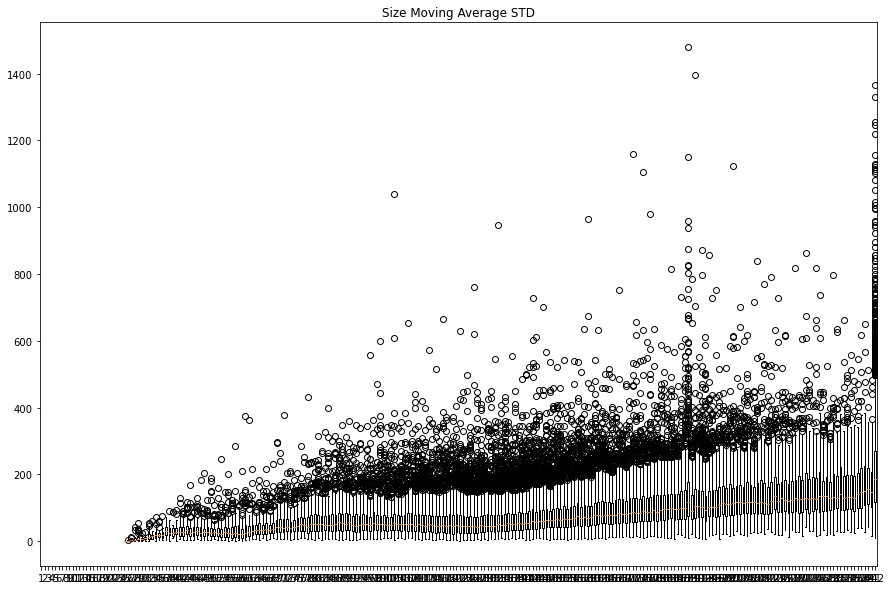

In [37]:
box_plot_data = []
temp = grouped[inital_mask]
for i in tqdm(ordered_sizes[:]):
    box_plot_data.append(temp[temp.Size==i]['std_S'].to_numpy())
plt.figure(figsize=(15,10))
plt.boxplot(box_plot_data)
plt.title("Size Moving Average STD")
plt.show()

In [38]:

temp = grouped[inital_mask]
identified_S = pd.Series()
for i in tqdm(ordered_sizes[:]):
    if i ==148 or i == 160:
        eliminate_outlier(temp[temp.Size==i]['std_S'],o=True)
    identified_S=identified_S.append(eliminate_outlier(temp[temp.Size==i]['std_S']))

<ipython-input-38-f5b9fb97af67>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = grouped[inital_mask]
<ipython-input-38-f5b9fb97af67>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  identified_S = pd.Series()
 75%|███████████████████████████████████████████████████████████▍                   | 182/242 [00:00<00:00, 424.50it/s]

-38.295280902400364 155.79599392554354
-52.144136232721266 200.533959995413


100%|███████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 367.09it/s]


In [39]:
sum(identified_S)/len(identified_S)

0.9562158450671107

In [40]:
print("Examin identified as good",np.random.choice(identified[identified].index,10))

Examin identified as good ['40B08WSS.avi' '45C9951U.avi' '2UYKAK1S.avi' '6FM8WBMO.avi'
 '43IXPYQY.avi' 'ECF8Z45L.avi' 'BMJSF1S2.avi' '3VA2N82Q.avi'
 '1FJ4G0HO.avi' '3YGCWJDK.avi']


In [41]:
print(sum(identified_S))

101662


In [42]:
sum(~identified_S)

4655

In [43]:

tirtiary_mask = identified_S & secondary_mask

In [44]:
sum(tirtiary_mask)/len(tirtiary_mask)

0.9200276625172891

In [45]:
np.random.choice(eval_mask(tirtiary_mask,secondary_mask),10)

New eliminations: 757


array(['CSDFA3FB.avi', '1GWKK530.avi', 'D1K6U4IK.avi', '9AH5DLUO.avi',
       'CWI9SDY8.avi', '2TKS99VC.avi', '810IS2QO.avi', 'AJ2I34C2.avi',
       '54QUSYVK.avi', '6P7Q9H4H.avi'], dtype=object)

1IACROT3.avi bad
40S77JY3.avi bad?
BN0675MN.avi bad
2PGFRQC7.avi bad?
5FRM4TDO.avi bad

In [46]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],tirtiary_mask['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],tirtiary_mask['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],tirtiary_mask['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],tirtiary_mask['5B6DUZ22.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True


# Evaluate by Binned mean Volume

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually STD_V for the average volume of the video

In [47]:
mean_grouped['Binned_Vol']=pd.qcut(mean_grouped['Volume'], q=100)
print(mean_grouped['Binned_Vol'].unique())
print(mean_grouped['Binned_Vol'].value_counts())
temp = mean_grouped.sort_values('Volume')[inital_mask]
temp.head()

[(-0.001, 4776.307], (15123.917, 15445.973], (5797.941, 6465.944], (8671.778, 9019.13], (4776.307, 5797.941], ..., (16129.981, 16453.012], (44771.919, 45898.57], (90602.568, 102648.276], (71312.294, 76073.267], (47149.589, 48464.425]]
Length: 100
Categories (100, interval[float64]): [(-0.001, 4776.307] < (4776.307, 5797.941] < (5797.941, 6465.944] < (6465.944, 7035.752] ... (82067.852, 90602.568] < (90602.568, 102648.276] < (102648.276, 122115.8] < (122115.8, 271569.837]]
(122115.8, 271569.837]    1085
(16129.981, 16453.012]    1085
(28975.43, 29553.068]     1085
(27851.919, 28391.994]    1085
(26727.003, 27270.927]    1085
                          ... 
(17143.383, 17490.508]    1084
(16453.012, 16795.862]    1084
(30797.018, 31393.973]    1084
(15774.192, 16129.981]    1084
(22826.058, 23286.796]    1084
Name: Binned_Vol, Length: 100, dtype: int64


<ipython-input-47-f7560b48b094>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = mean_grouped.sort_values('Volume')[inital_mask]


,frame number,Size,Volume,x1,y1,x2,y2,length,Degrees,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S,Binned_Vol
Filename,,,,,,,,,,,,,,,,
AEHG9NTV.avi,39.0,284.531646,1486.477869,57.037975,45.113924,54.379747,20.734177,24.608902,-95.926168,67.347744,1.156494e+05+0.000000e+00j,1.156494e+05+0.000000e+00j,6.466567,22167.000000+0.000000j,22167.000000+0.000000j,"(-0.001, 4776.307]"
549GM4FO.avi,120.0,698.788382,1881.572767,91.780083,78.892116,91.680498,42.510373,36.424530,-90.080639,604.776810,4.511347e+05+0.000000e+00j,4.511347e+05+0.000000e+00j,83.587712,167682.000000+0.000000j,167682.000000+0.000000j,"(-0.001, 4776.307]"
42L17LX9.avi,38.5,336.743590,2107.851923,60.230769,49.641026,58.000000,21.102564,28.689070,-94.626744,127.655811,1.615627e+05+0.000000e+00j,1.615627e+05+0.000000e+00j,15.675775,25881.000000+0.000000j,25881.000000+0.000000j,"(-0.001, 4776.307]"
6L2VWE4S.avi,25.5,607.173077,2149.449221,65.326923,58.692308,66.788462,23.576923,35.817397,-84.858102,3881.380322,6.508590e+06+0.000000e+00j,6.508590e+06+0.000000e+00j,125.649435,350689.000000+0.000000j,350689.000000+0.000000j,"(-0.001, 4776.307]"
BNYKJ944.avi,80.5,338.179012,2189.174601,56.771605,48.185185,51.987654,19.598765,29.030142,-99.378348,208.573512,3.524860e+05+0.000000e+00j,3.524860e+05+0.000000e+00j,16.013440,54434.000000+0.000000j,54434.000000+0.000000j,"(-0.001, 4776.307]"


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1302.68it/s]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


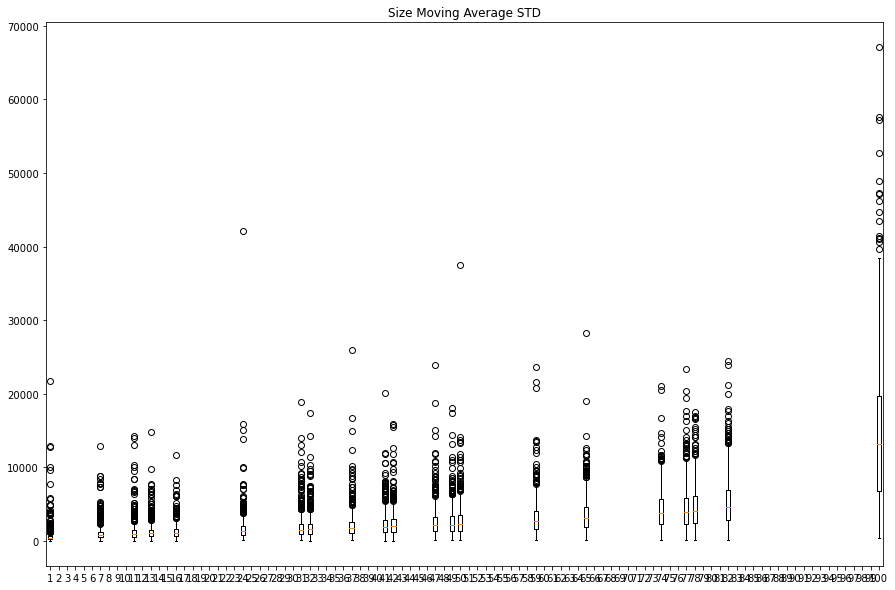

In [48]:
box_plot_data = []
ordered_sizes = temp['Binned_Vol'].unique()
for i in tqdm(ordered_sizes):
    box_plot_data.append(temp[temp['Binned_Vol']==i]['std_V'].to_numpy())
plt.figure(figsize=(15,10))
plt.boxplot(box_plot_data)
plt.title("Size Moving Average STD")
plt.show()

In [49]:
len(box_plot_data)

100

In [50]:

identified_MV = pd.Series()
for i in tqdm(ordered_sizes):
    if i ==148 or i == 160:
        eliminate_outlier(temp[temp['Binned_Vol']==i]['std_V'],o=True)
    identified_MV=identified_MV.append(eliminate_outlier(temp[temp['Binned_Vol']==i]['std_S']))

<ipython-input-50-a2e44e8bc3d1>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  identified_MV = pd.Series()
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.34it/s]


In [51]:
sum(identified_MV)/len(identified_MV)

0.9733062445328593

In [52]:
print("Examin identified as good",np.random.choice(identified_MV[identified_MV].index,10))

Examin identified as good ['56LIANAQ.avi' '81GQCOUC.avi' '6PPWXE6Y.avi' 'E6WYFOIL.avi'
 'CSCRF65Z.avi' '2LSAQ3O0.avi' '5BN99RB4.avi' '5EUPA0WF.avi'
 'FIO9RC24.avi' '3VPGDOH7.avi']


In [53]:
sum(~identified_MV)

2838

In [54]:

mask4 = identified_MV & tirtiary_mask

In [55]:
sum(mask4)/len(mask4)

0.9015952051636699

In [56]:
def eval_mask(new_mask,old_mask):
    print("New eliminations:",sum(~new_mask)-sum(~old_mask))
    
    return old_mask[(new_mask==False) & (old_mask == True)].index
np.random.choice(eval_mask(mask4,tirtiary_mask),10)

New eliminations: 1999


array(['6RZMG19M.avi', '6NVXEALT.avi', 'BSJAAAQP.avi', 'BJCUITUT.avi',
       '432E6KN8.avi', '2M8ZY0CO.avi', '59BWNYV4.avi', '1ELJPF87.avi',
       '6G248GYZ.avi', '3XJRSHG6.avi'], dtype=object)

6K6T3LNN.avi bad
6EOIEPY8.avi good
6S0RXSMD.avi bad
6FM8OHW3.avi bad?
6MYJ3DTD.avi good

In [57]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],mask4['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],mask4['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],mask4['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],mask4['5B6DUZ22.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True


# Evaluate by Binned std Volume

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually STD_V for the standard deviation of the volume of the video

In [58]:
std_grouped['Binned_Vol']=pd.qcut(std_grouped['Volume'], q=100)
print(std_grouped['Binned_Vol'].unique())
print(std_grouped['Binned_Vol'].value_counts())
temp = std_grouped.sort_values('Volume')[inital_mask]
temp.head()

[(-0.001, 1370.403], (4285.255, 4380.86], (5914.141, 6040.89], (2192.0, 2326.88], (6718.324, 6862.33], ..., (5428.648, 5545.413], (4474.267, 4573.052], (21076.903, 22255.089], (18522.739, 19264.872], NaN]
Length: 101
Categories (100, interval[float64]): [(-0.001, 1370.403] < (1370.403, 1662.161] < (1662.161, 1870.262] < (1870.262, 2043.362] ... (25727.19, 28261.515] < (28261.515, 32258.982] < (32258.982, 39123.926] < (39123.926, 102166.353]]
(39123.926, 102166.353]    1085
(10063.352, 10283.743]     1085
(9238.885, 9439.822]       1085
(8870.146, 9050.309]       1085
(8510.181, 8696.038]       1085
                           ... 
(5314.809, 5428.648]       1084
(5090.077, 5202.368]       1084
(9848.426, 10063.352]      1084
(4881.809, 4988.178]       1084
(14489.651, 14883.222]     1084
Name: Binned_Vol, Length: 100, dtype: int64


<ipython-input-58-df90853f9a7c>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = std_grouped.sort_values('Volume')[inital_mask]


,frame number,Size,Volume,x1,y1,x2,y2,length,Degrees,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S,Binned_Vol
Filename,,,,,,,,,,,,,,,,
6IDB4GU4.avi,25.547342,24.205276,333.137631,1.139614,1.133696,0.957564,1.176607,1.858362,1.851345,1759.128545,5.545324e+06+0.000000e+00j,5.545324e+06+0.000000e+00j,49.959987,290451.000000+0.000000j,290451.000000+0.000000j,"(-0.001, 1370.403]"
AEHG9NTV.avi,22.949219,31.080473,355.651289,1.043208,1.012579,1.587643,2.055068,2.385196,4.839361,67.347744,1.156494e+05+0.000000e+00j,1.156494e+05+0.000000e+00j,6.466567,22167.000000+0.000000j,22167.000000+0.000000j,"(-0.001, 1370.403]"
E6GPXYLR.avi,40.558600,24.105262,394.316595,1.038098,1.415285,1.053160,0.968014,1.695314,2.370138,98.512337,6.232229e+05-2.842171e-12j,6.232229e+05-2.842171e-12j,5.843609,73694.000000+0.000000j,73694.000000+0.000000j,"(-0.001, 1370.403]"
1K4NWEX4.avi,34.785054,27.749781,433.494681,1.866031,0.869294,1.831085,1.855871,1.679453,2.393072,144.869811,5.124622e+05+0.000000e+00j,5.124622e+05+0.000000e+00j,9.476550,64550.000000+0.000000j,64550.000000+0.000000j,"(-0.001, 1370.403]"
2KVOU9KH.avi,30.166206,38.648775,447.962795,1.103325,1.218440,1.345476,2.004755,2.295915,2.397237,236.838021,4.147131e+05+1.818989e-12j,4.147131e+05+1.818989e-12j,19.898819,53237.000000+0.000000j,53237.000000+0.000000j,"(-0.001, 1370.403]"


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1302.30it/s]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


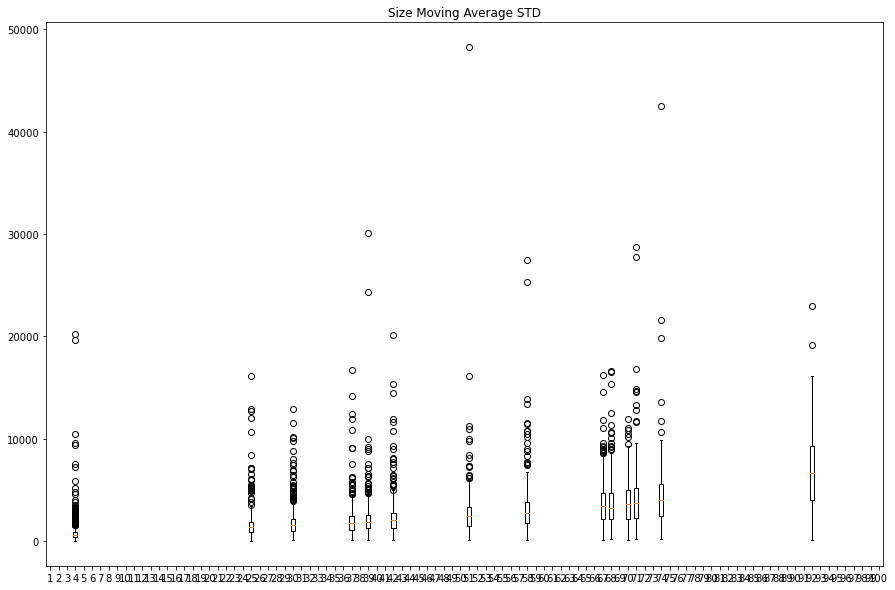

In [59]:
box_plot_data = []
ordered_sizes = temp['Binned_Vol'].unique()
for i in tqdm(ordered_sizes):
    box_plot_data.append(temp[temp['Binned_Vol']==i]['std_V'].to_numpy())
plt.figure(figsize=(15,10))
plt.boxplot(box_plot_data)
plt.title("Size Moving Average STD")
plt.show()

In [60]:
len(box_plot_data)

100

In [61]:

mask5 = pd.Series()
for i in tqdm(ordered_sizes):
    if i ==148 or i == 160:
        eliminate_outlier(temp[temp['Binned_Vol']==i]['std_V'],o=True)
    mask5=mask5.append(eliminate_outlier(temp[temp['Binned_Vol']==i]['std_S']))

<ipython-input-61-e5c1f4172c1e>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mask5 = pd.Series()
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 311.37it/s]


In [62]:
sum(mask5)/len(mask5)

0.9822982213568855

In [63]:
print("Examin identified as good",np.random.choice(mask5[mask5].index,10))

Examin identified as good ['EA4QC28Y.avi' 'BQ8XAQHE.avi' '96DSG9PF.avi' '2O25WOM0.avi'
 '6HVXZV2O.avi' '804FT3ES.avi' '6KN68K6H.avi' '2T4WO6IZ.avi'
 '571DICPW.avi' '6F5JG9L8.avi']


In [64]:
sum(~mask5)

1882

In [65]:

mask5 = mask5 & mask4

In [66]:
sum(mask5)/len(mask5)

0.8979529737206086

In [67]:
sum(mask5)

97383

In [68]:
np.random.choice(eval_mask(mask5,mask4),10)

New eliminations: 395


array(['6M1LW5T0.avi', '5AOZVVWK.avi', '6ITOBIY4.avi', '6PO3G7IS.avi',
       '6IDBB71J.avi', '6ITZDGM8.avi', '6KN09WCQ.avi', '6LK9A4UI.avi',
       '6G2M7CFC.avi', '6FLX1VLA.avi'], dtype=object)

6KNC2J9D.avi good

2WD62GAS.avi good?

6F5PCOF7.avi good

6ITZDGM8.avi good

EE9QPE7K.avi bad

5FAWMYMH.avi bad ?



In [69]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],mask5['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],mask5['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],mask5['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],mask5['5B6DUZ22.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True


# Evaluate by Binned range Volume

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually STD_V for the range of the volume of the video

In [70]:
range_grouped['Binned_Vol']=pd.qcut(range_grouped['Volume'], q=100)
print(range_grouped['Binned_Vol'].unique())
print(range_grouped['Binned_Vol'].value_counts())
temp = range_grouped.sort_values('Volume')[inital_mask]
temp.head()

[(-0.001, 3480.738], (7765.207, 8018.012], (16361.071, 16696.03], (4260.345, 4805.091], (11149.005, 11391.922], ..., (41002.026, 42179.643], (15358.77, 15682.05], (11902.503, 12165.38], (34157.366, 35015.466], (48269.039, 50213.024]]
Length: 100
Categories (100, interval[float64]): [(-0.001, 3480.738] < (3480.738, 4260.345] < (4260.345, 4805.091] < (4805.091, 5284.264] ... (67202.611, 73860.224] < (73860.224, 84174.098] < (84174.098, 101855.524] < (101855.524, 275965.214]]
(101855.524, 275965.214]    1085
(12716.423, 12990.552]      1085
(23485.09, 23983.346]       1085
(22536.967, 22997.986]      1085
(21574.094, 22079.494]      1085
                            ... 
(13524.743, 13827.621]      1084
(12990.552, 13254.231]      1084
(25044.993, 25580.63]       1084
(12440.264, 12716.423]      1084
(18180.02, 18569.217]       1084
Name: Binned_Vol, Length: 100, dtype: int64


<ipython-input-70-75d7d0c18889>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = range_grouped.sort_values('Volume')[inital_mask]


,Size,Volume,x1,y1,x2,y2,length,Degrees,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S,Binned_Vol
Filename,,,,,,,,,,,,,,,
6IDB4GU4.avi,60.4,756.768437,3.3,3.0,2.0,4.0,4.395396,4.639447,1759.128545,5.545324e+06+0.000000e+00j,5.545324e+06+0.000000e+00j,49.959987,290451.000000+0.000000j,290451.000000+0.000000j,"(-0.001, 3480.738]"
AEHG9NTV.avi,79.2,890.213302,3.0,2.0,3.0,6.0,6.294688,11.833583,67.347744,1.156494e+05+0.000000e+00j,1.156494e+05+0.000000e+00j,6.466567,22167.000000+0.000000j,22167.000000+0.000000j,"(-0.001, 3480.738]"
E6GPXYLR.avi,60.4,1035.510304,2.0,4.0,3.0,2.0,4.201770,6.170175,98.512337,6.232229e+05-2.842171e-12j,6.232229e+05-2.842171e-12j,5.843609,73694.000000+0.000000j,73694.000000+0.000000j,"(-0.001, 3480.738]"
1K4NWEX4.avi,73.1,1098.057687,4.1,2.0,4.1,4.0,3.514583,5.467102,144.869811,5.124622e+05+0.000000e+00j,5.124622e+05+0.000000e+00j,9.476550,64550.000000+0.000000j,64550.000000+0.000000j,"(-0.001, 3480.738]"
1IAIKVTP.avi,113.4,1122.377518,4.0,10.0,4.0,8.0,8.182064,5.899667,152.858351,3.708896e+05+7.730705e-12j,3.708896e+05+7.730705e-12j,17.314999,53750.000000+0.000000j,53750.000000+0.000000j,"(-0.001, 3480.738]"


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1336.90it/s]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\TheurerJ\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


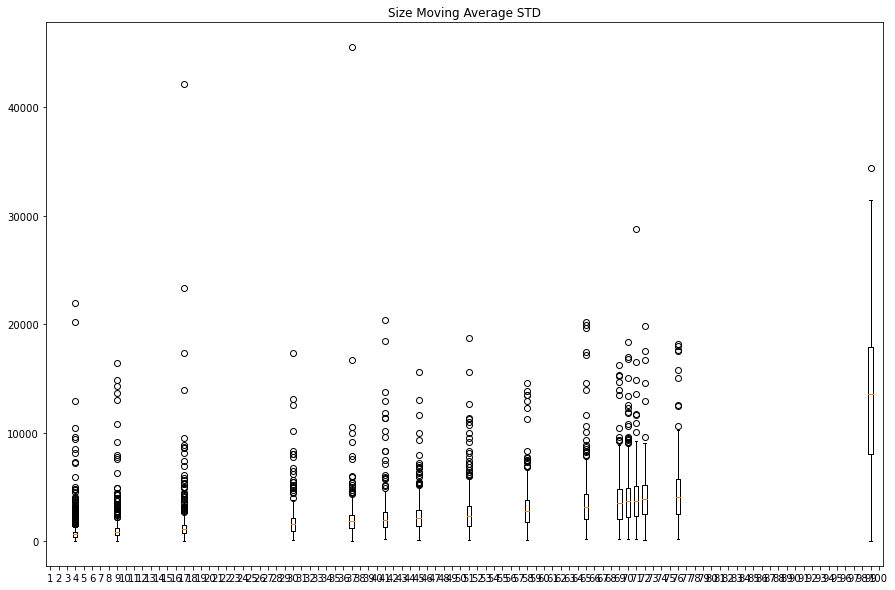

In [71]:
box_plot_data = []
ordered_sizes = temp['Binned_Vol'].unique()
for i in tqdm(ordered_sizes):
    box_plot_data.append(temp[temp['Binned_Vol']==i]['std_V'].to_numpy())
plt.figure(figsize=(15,10))
plt.boxplot(box_plot_data)
plt.title("Size Moving Average STD")
plt.show()

In [72]:
len(box_plot_data)

100

In [73]:

mask6 = pd.Series()
for i in tqdm(ordered_sizes):
    mask6=mask6.append(eliminate_outlier(temp[temp['Binned_Vol']==i]['std_S']))

<ipython-input-73-6fa21fc24040>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mask6 = pd.Series()
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 310.42it/s]


In [74]:
sum(mask6)/len(mask6)

0.9800972563183686

In [75]:
print("Examin identified as good",np.random.choice(mask6[mask6].index,10))

Examin identified as good ['6LJ955VY.avi' 'D3DOEX07.avi' '469ZSDAY.avi' '6RZS3K6O.avi'
 '6E84WYML.avi' '3USDRJBL.avi' 'D5PP9LID.avi' '6MYJ7VGN.avi'
 '431QNVB0.avi' '469BWC50.avi']


In [76]:
sum(~mask6)

2116

In [77]:

mask6 = mask6 & mask5

In [78]:
sum(mask6)/len(mask6)

0.8970401106500692

In [79]:
sum(mask6)

97284

In [80]:
np.random.choice(eval_mask(mask6,mask5),10)

New eliminations: 99


array(['E97ZHPDS.avi', '6F5DOWHY.avi', '59SXTMRZ.avi', '1KK7LU5G.avi',
       '6G2M5A4R.avi', '99KKAZQE.avi', '59SXTMRZ.avi', 'BLN1RKKH.avi',
       '5CKHX1S6.avi', 'E97ZHPDS.avi'], dtype=object)

6K6T3LNN.avi bad
6EOIEPY8.avi good
6S0RXSMD.avi bad
6FM8OHW3.avi bad?
6MYJ3DTD.avi good

In [81]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],mask6['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],mask6['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],mask6['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],mask6['5B6DUZ22.avi'])
print('bad',mask6['5B5E9X23.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True
bad True


# FFT Calc mean Volume

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually FF1_V for the mean volume of the video

In [82]:
temp = mean_grouped.sort_values('Volume')[mask6]
temp.head()

<ipython-input-82-5ed26a9e3fab>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = mean_grouped.sort_values('Volume')[mask6]


,frame number,Size,Volume,x1,y1,x2,y2,length,Degrees,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S,Binned_Vol
Filename,,,,,,,,,,,,,,,,
AEHG9NTV.avi,39.0,284.531646,1486.477869,57.037975,45.113924,54.379747,20.734177,24.608902,-95.926168,67.347744,115649.401785+0.000000j,115649.401785+0.000000j,6.466567,22167.000000+0.000000j,22167.000000+0.000000j,"(-0.001, 4776.307]"
42L17LX9.avi,38.5,336.743590,2107.851923,60.230769,49.641026,58.000000,21.102564,28.689070,-94.626744,127.655811,161562.651426+0.000000j,161562.651426+0.000000j,15.675775,25881.000000+0.000000j,25881.000000+0.000000j,"(-0.001, 4776.307]"
BNYKJ944.avi,80.5,338.179012,2189.174601,56.771605,48.185185,51.987654,19.598765,29.030142,-99.378348,208.573512,352486.003174+0.000000j,352486.003174+0.000000j,16.013440,54434.000000+0.000000j,54434.000000+0.000000j,"(-0.001, 4776.307]"
40C028WK.avi,47.5,385.979167,2243.606248,54.562500,60.593750,52.822917,26.062500,34.614642,-92.832698,210.292049,212753.921692+0.000000j,212753.921692+0.000000j,22.666938,36639.000000+0.000000j,36639.000000+0.000000j,"(-0.001, 4776.307]"
3YHU8MYA.avi,62.0,383.440000,2312.497434,60.704000,54.800000,59.128000,23.824000,31.069169,-93.046381,262.978136,287943.921926+0.000000j,287943.921926+0.000000j,20.752818,47669.000000+0.000000j,47669.000000+0.000000j,"(-0.001, 4776.307]"


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1336.91it/s]


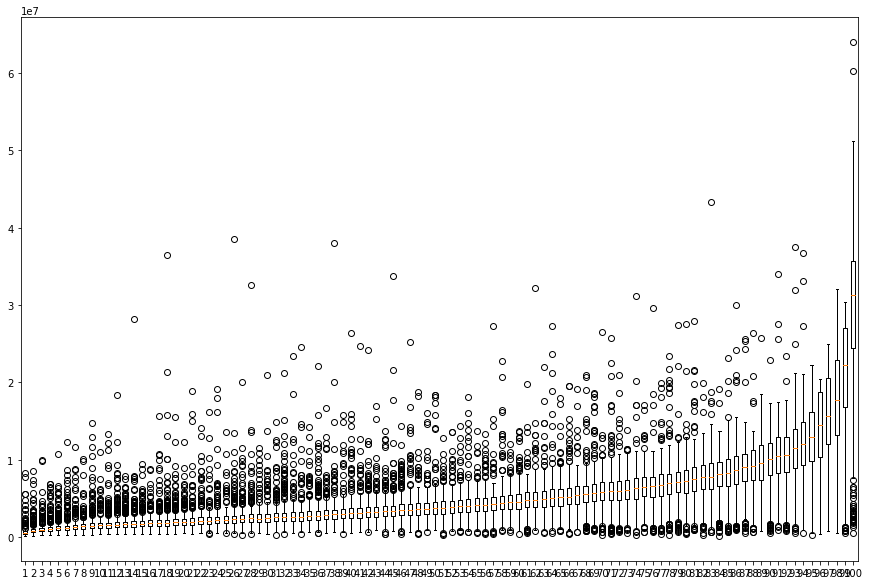

In [83]:
box_plot_data = []
ordered_sizes = temp['Binned_Vol'].unique()
for i in tqdm(ordered_sizes):
    box_plot_data.append(np.absolute(temp[temp['Binned_Vol']==i]['fft1_V'].to_numpy()))
plt.figure(figsize=(15,10))
plt.boxplot(box_plot_data)
plt.show()

In [84]:
len(box_plot_data)

100

In [85]:

mask7 = pd.Series()
for i in tqdm(ordered_sizes):
    mask7=mask7.append(eliminate_outlier(np.absolute(temp[temp['Binned_Vol']==i]['fft1_V'])))

<ipython-input-85-aa7c8f4fc2b4>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mask7 = pd.Series()
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 294.90it/s]


In [86]:
sum(mask7)/len(mask7)

0.9804387155133424

In [87]:
print("Examin identified as good",np.random.choice(mask7[mask7].index,10))

Examin identified as good ['1K4BVX2C.avi' '1BUTE5JB.avi' '6E7SYFJ5.avi' '1HCXXQNZ.avi'
 '5G8SYP8U.avi' 'BM48S5CZ.avi' '5GOURXX2.avi' 'BL6CI4PT.avi'
 'BIW5JD09.avi' '6NV3RGQI.avi']


In [88]:
print(sum(~mask7),sum(mask7))

1903 95381


In [89]:

mask7 = mask7 & mask6

In [90]:
sum(mask7)/len(mask7)

0.8794928538497003

In [91]:
sum(mask7)

95381

In [92]:
np.random.choice(eval_mask(mask7,mask6),10)

New eliminations: 1903


array(['6EO0CIFN.avi', '6F4PKCUJ.avi', '6MY18L7H.avi', '6JQL7Z4I.avi',
       '6M1G2FA7.avi', '6Q64EWPG.avi', '6G247JXH.avi', '6GJ5SVW9.avi',
       '6L4DLNUM.avi', '6LK8XEIA.avi'], dtype=object)

6EP09I4X.avi good
6NEWLBS4.avi good?
6K6YP3K5.avi bad
6P97OASF.avi good
6P9JPCS3.avi good?
6GZ12P2X.avi good
6JPXH6IH.avi good
6JA1WRPM.avi good
6JQFCELL.avi good
6OBN09WN.avi good?

Disclude mask 7?

In [93]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],mask7['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],mask7['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],mask7['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],mask7['5B6DUZ22.avi'])
print('bad',mask7['5B5E9X23.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True
bad True


# FFT Calc mean Volume, eliminate top

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually FF1_V for the mean volume of the video, this time by finding a cuttoff line.

In [94]:
temp = mean_grouped.sort_values('Volume')[inital_mask]
temp.head()

<ipython-input-94-0cce7b1efc68>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = mean_grouped.sort_values('Volume')[inital_mask]


,frame number,Size,Volume,x1,y1,x2,y2,length,Degrees,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S,Binned_Vol
Filename,,,,,,,,,,,,,,,,
AEHG9NTV.avi,39.0,284.531646,1486.477869,57.037975,45.113924,54.379747,20.734177,24.608902,-95.926168,67.347744,1.156494e+05+0.000000e+00j,1.156494e+05+0.000000e+00j,6.466567,22167.000000+0.000000j,22167.000000+0.000000j,"(-0.001, 4776.307]"
549GM4FO.avi,120.0,698.788382,1881.572767,91.780083,78.892116,91.680498,42.510373,36.424530,-90.080639,604.776810,4.511347e+05+0.000000e+00j,4.511347e+05+0.000000e+00j,83.587712,167682.000000+0.000000j,167682.000000+0.000000j,"(-0.001, 4776.307]"
42L17LX9.avi,38.5,336.743590,2107.851923,60.230769,49.641026,58.000000,21.102564,28.689070,-94.626744,127.655811,1.615627e+05+0.000000e+00j,1.615627e+05+0.000000e+00j,15.675775,25881.000000+0.000000j,25881.000000+0.000000j,"(-0.001, 4776.307]"
6L2VWE4S.avi,25.5,607.173077,2149.449221,65.326923,58.692308,66.788462,23.576923,35.817397,-84.858102,3881.380322,6.508590e+06+0.000000e+00j,6.508590e+06+0.000000e+00j,125.649435,350689.000000+0.000000j,350689.000000+0.000000j,"(-0.001, 4776.307]"
BNYKJ944.avi,80.5,338.179012,2189.174601,56.771605,48.185185,51.987654,19.598765,29.030142,-99.378348,208.573512,3.524860e+05+0.000000e+00j,3.524860e+05+0.000000e+00j,16.013440,54434.000000+0.000000j,54434.000000+0.000000j,"(-0.001, 4776.307]"


In [95]:
slope = (max(np.absolute(temp['fft1_V'].to_numpy()))/np.max(temp['Volume']))
print(slope)

248.93589729500522


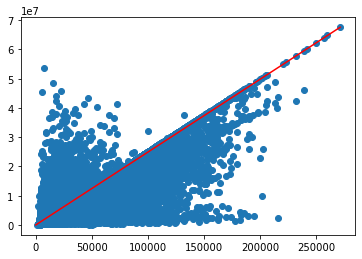

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


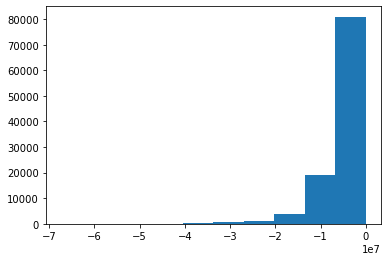

-59786.204673050874

In [96]:
plt.scatter(temp['Volume'],np.absolute(temp['fft1_V'].to_numpy()))
plt.plot([0,np.max(temp['Volume'])],[0,max(np.absolute(temp['fft1_V'].to_numpy()))],color='red')
plt.show()
plt.hist(temp['Volume']-np.absolute(temp['fft1_V'].to_numpy()))
plt.show()
max(temp['Volume']-np.absolute(temp['fft1_V'].to_numpy()))

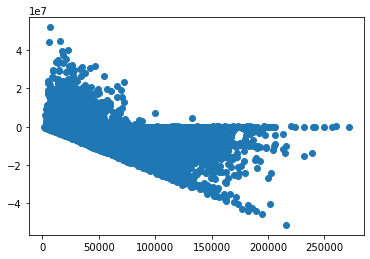

In [97]:
plt.scatter(temp['Volume'],np.absolute(temp['fft1_V'].to_numpy())-slope*temp['Volume'])

In [98]:
(np.absolute(temp['fft1_V'].to_numpy())-slope*temp['Volume'])>0

Filename
AEHG9NTV.avi    False
549GM4FO.avi    False
42L17LX9.avi    False
6L2VWE4S.avi     True
BNYKJ944.avi    False
                ...  
CXW81F4H.avi     True
440AXELY.avi    False
57HX3V01.avi     True
5C3MMF3F.avi     True
1F2ET6C3.avi    False
Name: Volume, Length: 106317, dtype: bool

In [99]:

mask8 = (np.absolute(temp['fft1_V'].to_numpy())-248.93589729500522*temp['Volume'])<0


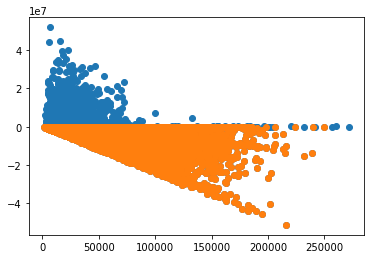

In [100]:
plt.scatter(temp['Volume'],np.absolute(temp['fft1_V'].to_numpy())-248.93589729500522*temp['Volume'])
plt.scatter(temp[mask8]['Volume'],np.absolute(temp[mask8]['fft1_V'].to_numpy())-248.93589729500522*temp[mask8]['Volume'])

In [101]:
sum(mask8)/len(mask8)

0.9377145705766716

In [102]:
print("Examin identified as good",np.random.choice(mask8[mask8].index,10))

Examin identified as good ['6IS16VTV.avi' '5H4Q82N6.avi' '54QJ3JNV.avi' '46RCVDE5.avi'
 '5DGWULQK.avi' '3XKKH0RQ.avi' '7WF4Z1DL.avi' 'BQ995M98.avi'
 '2LSGQN9K.avi' '6S03Y9EE.avi']


In [103]:
print(sum(~mask8),sum(mask8))

6622 99695


In [104]:

mask8 = mask8 & mask6

In [105]:
sum(mask8)/len(mask8)

0.8534163208852006

In [106]:
sum(mask8)

92553

In [107]:
np.random.choice(eval_mask(mask8,mask6),10)

New eliminations: 4731


array(['1E5OC6W7.avi', '6L4PCM1J.avi', 'BRMJD5JU.avi', '6ICHM5Y9.avi',
       'D2184LIB.avi', 'BTGOTKVI.avi', '1J7993UI.avi', 'E7D0AENY.avi',
       '6NV9MR9D.avi', '6KO04HTC.avi'], dtype=object)

E6WGUYJR.avi bad?

7XC7WH0A.avi good

6Q64TF6U.avi bad

6MXP3BS7.avi bad

6IDHB9QW.avi good?

In [108]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],mask8['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],mask8['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],mask8['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],mask8['5B6DUZ22.avi'])
print('bad',mask8['5B5E9X23.avi'])
print('bad',mask8['6ORURZ6D.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True
bad True
bad True


# FFT Calc mean Size, eliminate based on size

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with unusually FF1_S for the mean Size of the video, this time by finding a cuttoff line.

In [109]:
temp = mean_grouped.sort_values('Size')[inital_mask]
temp.head()

<ipython-input-109-287faf2a0a1c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = mean_grouped.sort_values('Size')[inital_mask]


,frame number,Size,Volume,x1,y1,x2,y2,length,Degrees,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S,Binned_Vol
Filename,,,,,,,,,,,,,,,,
AEHG9NTV.avi,39.0,284.531646,1486.477869,57.037975,45.113924,54.379747,20.734177,24.608902,-95.926168,67.347744,115649.401785+0.000000j,115649.401785+0.000000j,6.466567,22167.000000+0.000000j,22167.000000+0.000000j,"(-0.001, 4776.307]"
2OIJFR77.avi,51.0,304.825243,2598.081550,69.572816,67.359223,66.621359,49.058252,19.534623,-97.276674,81.551436,264564.882418+0.000000j,264564.882418+0.000000j,6.713576,31074.000000+0.000000j,31074.000000+0.000000j,"(-0.001, 4776.307]"
42L17LX9.avi,38.5,336.743590,2107.851923,60.230769,49.641026,58.000000,21.102564,28.689070,-94.626744,127.655811,161562.651426+0.000000j,161562.651426+0.000000j,15.675775,25881.000000+0.000000j,25881.000000+0.000000j,"(-0.001, 4776.307]"
BNYKJ944.avi,80.5,338.179012,2189.174601,56.771605,48.185185,51.987654,19.598765,29.030142,-99.378348,208.573512,352486.003174+0.000000j,352486.003174+0.000000j,16.013440,54434.000000+0.000000j,54434.000000+0.000000j,"(-0.001, 4776.307]"
AH8CUKT7.avi,75.0,358.516556,2765.933749,58.450331,56.496689,55.410596,33.079470,23.848082,-97.162950,358.749861,415581.148796+0.000000j,415581.148796+0.000000j,31.956109,53800.000000+0.000000j,53800.000000+0.000000j,"(-0.001, 4776.307]"


In [110]:
slope = (max(np.absolute(temp['fft1_S'].to_numpy()))/np.max(temp['Size']))
print(slope)

248.96467698185694


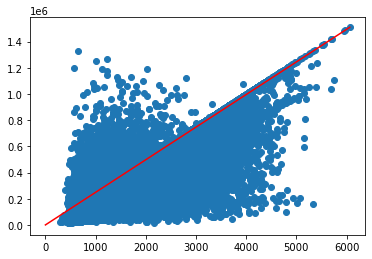

In [111]:
plt.scatter(temp['Size'],np.absolute(temp['fft1_S'].to_numpy()))
plt.plot([0,np.max(temp['Size'])],[0,slope*np.max(temp['Size'])],color='red')
plt.show()


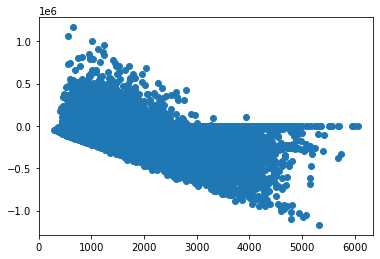

In [112]:
plt.scatter(temp['Size'],np.absolute(temp['fft1_S'].to_numpy())-slope*temp['Size'])

In [113]:
(np.absolute(temp['fft1_S'].to_numpy())-slope*temp['Size'])>0

Filename
AEHG9NTV.avi    False
2OIJFR77.avi    False
42L17LX9.avi    False
BNYKJ944.avi    False
AH8CUKT7.avi    False
                ...  
FIO9IVXB.avi     True
E5JC919R.avi    False
440AXELY.avi    False
5C3MMF3F.avi     True
1F2ET6C3.avi    False
Name: Size, Length: 106317, dtype: bool

In [114]:

mask9 = (np.absolute(temp['fft1_S'].to_numpy())-slope*temp['Size'])<0


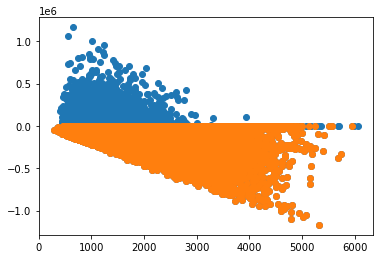

In [115]:
plt.scatter(temp['Size'],np.absolute(temp['fft1_S'].to_numpy())-slope*temp['Size'])
plt.scatter(temp[mask9]['Size'],np.absolute(temp[mask9]['fft1_S'].to_numpy())-slope*temp[mask9]['Size'])

In [116]:
sum(mask9)/len(mask9)

0.9474307965800389

In [117]:
print("Examin identified as good",np.random.choice(mask9[mask9].index,10))

Examin identified as good ['FKYYBTGC.avi' '44GO5DLH.avi' '2QD6HR0N.avi' '6JR35ZNI.avi'
 'E7SPUIDU.avi' 'BHYQUM6K.avi' '5APUIA1D.avi' '1K4AX0T8.avi'
 '1NBRW8CY.avi' '1HTZ3I9A.avi']


In [118]:
print(sum(~mask9),sum(mask9))

5589 100728


In [119]:

mask9 = mask9 & mask8

In [120]:
sum(mask9)/len(mask9)

0.8527985246657446

In [121]:
sum(mask9)

92486

In [122]:
np.random.choice(eval_mask(mask9,mask8),10)

New eliminations: 67


array(['6GZV2QSM.avi', '1F1RAJYO.avi', '2VV47JEE.avi', '6E8GIIOZ.avi',
       'CZ96CUG6.avi', '6QMI0MAG.avi', '93MK84H0.avi', '58UDDR7G.avi',
       '6HVY6JQO.avi', '5FAQT1ON.avi'], dtype=object)

BSK41RZF.avi bad? (single spot?)

3UBOK2YV.avi good?

93MK84H0.avi bad

AFE7CGQ2.avi bad

A8IGBVT7.avi good?

In [123]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],mask9['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],mask9['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],mask9['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],mask9['5B6DUZ22.avi'])
print('bad',mask9['5B5E9X23.avi'])
print('bad',mask9['6ORURZ6D.avi'])
print("bad?",mask9['ALTW3UL1.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True
bad True
bad True
bad? True


# FFT vs Moving Average std

This analysis removes the outlier videos, where outlier videos are calculated by identifying videos with high normalized FFT and Moving Averages

In [124]:
temp = mean_grouped.sort_values('Volume')[inital_mask]
temp.head()

<ipython-input-124-0cce7b1efc68>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = mean_grouped.sort_values('Volume')[inital_mask]


,frame number,Size,Volume,x1,y1,x2,y2,length,Degrees,std_V,fft1_V,fft2_V,std_S,fft1_S,fft2_S,Binned_Vol
Filename,,,,,,,,,,,,,,,,
AEHG9NTV.avi,39.0,284.531646,1486.477869,57.037975,45.113924,54.379747,20.734177,24.608902,-95.926168,67.347744,1.156494e+05+0.000000e+00j,1.156494e+05+0.000000e+00j,6.466567,22167.000000+0.000000j,22167.000000+0.000000j,"(-0.001, 4776.307]"
549GM4FO.avi,120.0,698.788382,1881.572767,91.780083,78.892116,91.680498,42.510373,36.424530,-90.080639,604.776810,4.511347e+05+0.000000e+00j,4.511347e+05+0.000000e+00j,83.587712,167682.000000+0.000000j,167682.000000+0.000000j,"(-0.001, 4776.307]"
42L17LX9.avi,38.5,336.743590,2107.851923,60.230769,49.641026,58.000000,21.102564,28.689070,-94.626744,127.655811,1.615627e+05+0.000000e+00j,1.615627e+05+0.000000e+00j,15.675775,25881.000000+0.000000j,25881.000000+0.000000j,"(-0.001, 4776.307]"
6L2VWE4S.avi,25.5,607.173077,2149.449221,65.326923,58.692308,66.788462,23.576923,35.817397,-84.858102,3881.380322,6.508590e+06+0.000000e+00j,6.508590e+06+0.000000e+00j,125.649435,350689.000000+0.000000j,350689.000000+0.000000j,"(-0.001, 4776.307]"
BNYKJ944.avi,80.5,338.179012,2189.174601,56.771605,48.185185,51.987654,19.598765,29.030142,-99.378348,208.573512,3.524860e+05+0.000000e+00j,3.524860e+05+0.000000e+00j,16.013440,54434.000000+0.000000j,54434.000000+0.000000j,"(-0.001, 4776.307]"


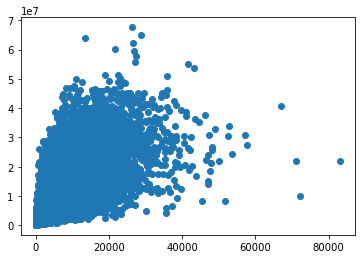

In [125]:
plt.scatter(temp['std_V'],np.absolute(temp['fft1_V'].to_numpy()))
#plt.plot([0,np.max(temp['Size'])],[0,slope*np.max(temp['Size'])],color='red')
plt.show()


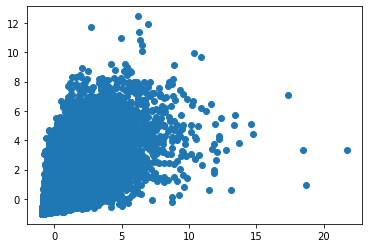

In [126]:
normalized_std = (temp['std_V']-np.mean(temp['std_V']))/np.std(temp['std_V'])
normalized_fft = (np.absolute(temp['fft1_V'])-np.mean(np.absolute(temp['fft1_V'])))/np.std(np.absolute(temp['fft1_V']))
plt.scatter(normalized_std,normalized_fft)

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


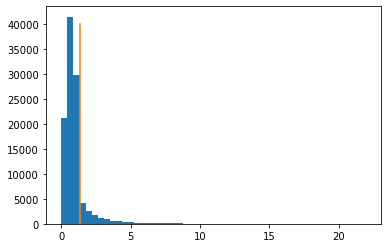

[2.79996070e-03 4.41883727e-01 8.80967494e-01 1.32005126e+00
 1.75913503e+00 2.19821879e+00 2.63730256e+00 3.07638633e+00
 3.51547010e+00 3.95455386e+00 4.39363763e+00 4.83272140e+00
 5.27180516e+00 5.71088893e+00 6.14997270e+00 6.58905646e+00
 7.02814023e+00 7.46722400e+00 7.90630776e+00 8.34539153e+00
 8.78447530e+00 9.22355906e+00 9.66264283e+00 1.01017266e+01
 1.05408104e+01 1.09798941e+01 1.14189779e+01 1.18580617e+01
 1.22971454e+01 1.27362292e+01 1.31753130e+01 1.36143967e+01
 1.40534805e+01 1.44925643e+01 1.49316480e+01 1.53707318e+01
 1.58098156e+01 1.62488993e+01 1.66879831e+01 1.71270669e+01
 1.75661506e+01 1.80052344e+01 1.84443182e+01 1.88834019e+01
 1.93224857e+01 1.97615695e+01 2.02006532e+01 2.06397370e+01
 2.10788208e+01 2.15179045e+01 2.19569883e+01]


In [127]:
dist = np.sqrt(normalized_std**2+normalized_fft**2)
bins = plt.hist(dist,bins=50)
plt.plot([1.32005126,1.32005126],[0,40000])
plt.show()
print(bins[1])

In [128]:
cuttoff = 1.32005126 # 5 is super strong
dist>cuttoff

Filename
AEHG9NTV.avi     True
549GM4FO.avi    False
42L17LX9.avi     True
6L2VWE4S.avi    False
BNYKJ944.avi    False
                ...  
CXW81F4H.avi     True
440AXELY.avi     True
57HX3V01.avi     True
5C3MMF3F.avi     True
1F2ET6C3.avi     True
Length: 106317, dtype: bool

In [129]:

mask10 = dist<cuttoff


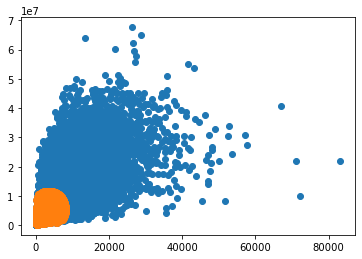

In [130]:
plt.scatter(temp['std_V'],np.absolute(temp['fft1_V'].to_numpy()))
plt.scatter(temp[mask10]['std_V'],np.absolute(temp[mask10]['fft1_V'].to_numpy()))

In [131]:
sum(mask10)/len(mask10)

0.8688638693717844

In [132]:
print("Examin identified as good",np.random.choice(mask10[mask10].index,10))

Examin identified as good ['BNXWIX3X.avi' '55MLVO0F.avi' 'CWHXPHLB.avi' 'E38NJZEY.avi'
 '1DP4PZSN.avi' '7WVITGHB.avi' '7QH54D2T.avi' 'D3DOPAMR.avi'
 '5DG37H09.avi' '43JLCW7R.avi']


In [133]:
print(sum(~mask10),sum(mask10))

13942 92375


In [134]:

mask10 = mask10 & mask9

In [135]:
sum(mask10)/len(mask10)

0.7860119870908253

In [136]:
sum(mask10)

85243

In [137]:
np.random.choice(eval_mask(mask10,mask9),10)

New eliminations: 7243


array(['CXFOB413.avi', 'FMT32PSK.avi', 'AGRT5H3U.avi', '5FRXN26D.avi',
       '424ZG8WS.avi', '6QMNYFS7.avi', '7WVOPCES.avi', '5EUD0NLR.avi',
       '418KIDCF.avi', 'D3U83BHH.avi'], dtype=object)

1CB6P9C1.avi bad?

ECF8YOJP.avi good

2UYKCURQ.avi bad?

1CRQ09LF.avi bad

E7DC7762.avi good

In [138]:
print("bad",grouped['std_S']['1AX2UAPB.avi'],mask9['1AX2UAPB.avi'])
print("good",grouped['std_S']['1AGCWGMH.avi'],mask9['1AGCWGMH.avi'])
print("bad",grouped['std_S']['1AXEKIJO.avi'],mask9['1AXEKIJO.avi'])
print("good",grouped['std_S']['5B6DUZ22.avi'],mask9['5B6DUZ22.avi'])
print('bad',mask9['5B5E9X23.avi'])
print('bad',mask9['6ORURZ6D.avi'])
print("bad?",mask9['ALTW3UL1.avi'])

bad 46.73253334343005 True
good 26.47765057975072 True
bad 250.34663977816393 False
good 13.727275575824695 True
bad True
bad True
bad? True


# End of Analysis

For continuation, repeat the analysis above with all right tailed distributions

In [139]:
mask10.to_csv("Filtered_Segmentations.csv")

In [260]:
grouped = total.groupby("Filename").count()
inital_mask = (grouped["Size"]>32) & (grouped["Problem"]==0)
grouped = grouped[inital_mask]
grouped.head()

,Size,Volume,x1,y1,x2,y2,length,Problem,frame,Degrees
Filename,,,,,,,,,,
1AFJUFVQ.avi,118,118,118,118,118,118,118,0,118,118
1AG1LTSE.avi,134,134,134,134,134,134,134,0,134,134
1AGCWGMH.avi,169,169,169,169,169,169,169,0,169,169
1AH0ALM3.avi,194,194,194,194,194,194,194,0,194,194
1AH0SCXW.avi,164,164,164,164,164,164,164,0,164,164


In [261]:

med_grouped = med_grouped[inital_mask]
med_grouped.head()

,Size,Volume,x1,y1,x2,y2,length,frame,Degrees
Filename,,,,,,,,,
1AFJUFVQ.avi,446.5,3777.984290,65.0,55.0,55.0,27.0,29.478728,58.5,-108.434949
1AG1LTSE.avi,1030.0,14712.967073,82.0,79.0,70.0,38.0,44.079421,66.5,-103.736268
1AGCWGMH.avi,742.0,9212.496057,71.0,71.0,69.0,32.0,39.204592,84.0,-95.572198
1AH0ALM3.avi,1974.5,41303.357196,60.0,97.0,60.0,30.0,67.007462,96.5,-90.000000
1AH0SCXW.avi,909.5,12608.365736,67.0,71.0,61.0,28.0,43.237684,81.5,-96.340192


In [262]:

std_grouped = std_grouped[inital_mask]
std_grouped.head()

,Size,Volume,x1,y1,x2,y2,length,frame,Degrees
Filename,,,,,,,,,
1AFJUFVQ.avi,43.163395,618.706560,1.076429,0.492152,1.662468,1.809563,1.926971,34.207699,3.800882
1AG1LTSE.avi,184.370357,4301.167195,4.081491,3.195506,2.377418,1.609453,3.344497,38.826537,6.437665
1AGCWGMH.avi,92.399405,2289.763715,1.350751,1.335832,1.672924,1.208242,1.998572,48.930222,3.173099
1AH0ALM3.avi,258.702103,8870.348173,2.446135,3.179297,1.703183,1.779405,3.665420,56.147128,3.033225
1AH0SCXW.avi,171.171316,4378.834740,1.072611,1.588185,2.289426,2.175619,3.529503,47.486840,3.001922


(array([6.3022e+04, 4.0300e+02, 2.0450e+03, 4.4000e+03, 6.0880e+03,
        5.7620e+03, 5.0730e+03, 4.1180e+03, 3.4040e+03, 2.8880e+03,
        2.2390e+03, 1.7620e+03, 1.3440e+03, 9.6800e+02, 6.8800e+02,
        5.1500e+02, 3.8000e+02, 2.7500e+02, 2.0600e+02, 1.7100e+02,
        1.3000e+02, 1.0800e+02, 8.4000e+01, 8.2000e+01, 7.3000e+01,
        6.5000e+01, 4.9000e+01, 3.7000e+01, 2.9000e+01, 2.0000e+01,
        1.9000e+01, 1.1000e+01, 7.0000e+00, 6.0000e+00, 6.0000e+00,
        7.0000e+00, 1.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0.        ,   34.09778905,   68.1955781 ,  102.29336715,
         136.3911562 ,  170.48894524,  204.58673429,  238.68452334,
         272.78231239,  306.88010144,  340.97789049,  375.07567954,
         409.17346859,  443.27125763,  477.36904668,  511.46683573,
         545.56462478,  579.66241383,  613.760

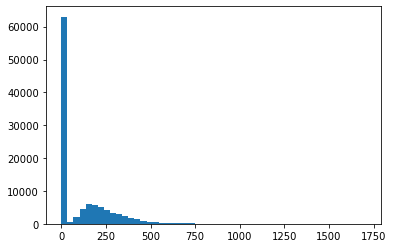

In [339]:
plt.hist(std_grouped['Size'],bins=50)

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


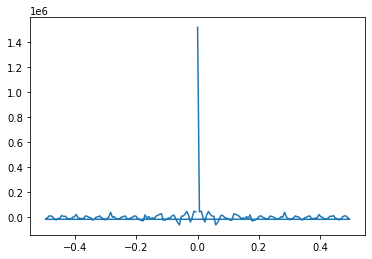

In [330]:
file_name = '1AGCWGMH.avi'
good1= np.fft.fft(total[total.Filename==file_name]['Volume'])
freq= np.fft.fftfreq(np.arange(0,len(np.fft.fft(total[total.Filename==file_name]['Volume']))).shape[-1])
plt.plot(freq,np.fft.fft(total[total.Filename==file_name]['Volume']))

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


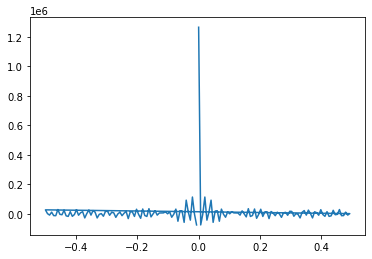

In [341]:
file_name = '1AX2UAPB.avi'#'1AXEKIJO.avi''1AXEKIJO.avi'
bad1 = np.fft.fft(total[total.Filename==file_name]['Volume'])
freq= np.fft.fftfreq(np.arange(0,len(np.fft.fft(total[total.Filename==file_name]['Volume']))).shape[-1])
plt.plot(freq,np.fft.fft(total[total.Filename==file_name]['Volume']))

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


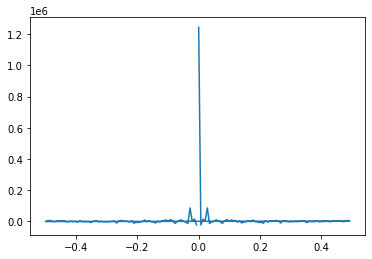

In [325]:
file_name = '5B6DUZ22.avi'
good2 = np.fft.fft(total[total.Filename==file_name]['Volume'])
freq= np.fft.fftfreq(np.arange(0,len(np.fft.fft(total[total.Filename==file_name]['Volume']))).shape[-1])
plt.plot(freq,np.fft.fft(total[total.Filename==file_name]['Volume']))

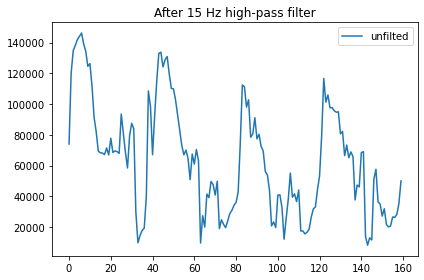

In [335]:
from scipy import signal
file_name = '1AXEKIJO.avi'
sig = total[total.Filename==file_name]['Volume'].to_numpy()
sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, sig)
plt.plot(range(0,len(sig)), sig,label="unfilted")
#plt.plot(range(0,len(sig)), filtered,label="filtered")
plt.legend()
plt.title('After 15 Hz high-pass filter')
plt.tight_layout()
plt.show()


True


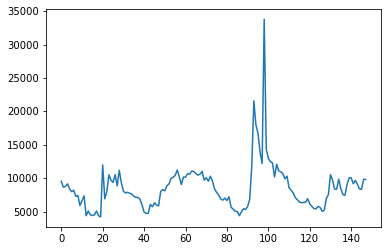

In [328]:
example_bad = '1AX2UAPB.avi'#'1AXEKIJO.avi'
print(inital_mask['1AXEKIJO.avi'])


plt.plot(total[total.Filename==example_bad]['Volume'].reset_index(drop=True))

In [316]:
sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()


NameError: name 'signal' is not defined

In [310]:
min(total[total.Filename==file_name]['Volume'])

0.0

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


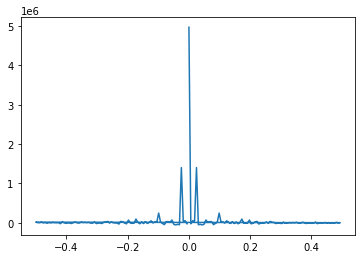

In [303]:

good3 = np.fft.fft(total[total.Filename=='5B6DXEDQ.avi']['Volume'])
freq= np.fft.fftfreq(np.arange(0,len(np.fft.fft(total[total.Filename=='5B6DXEDQ.avi']['Volume']))).shape[-1])
plt.plot(freq,np.fft.fft(total[total.Filename=='5B6DXEDQ.avi']['Volume']))

In [343]:
print(max(good1[1:]))
print(max(bad1[1:]))
print(max(good2[1:]))
print(max(good3[1:]))

(48129.12018783809+41315.68423202019j)
(113184.65835480396-30263.00661673202j)
(86722.19684772103+24189.508112642445j)
(1404074.0876688985+456793.0680276352j)


In [284]:
len(good1)-len(total[total.Filename=='1AGCWGMH.avi']['Volume'])

0

In [336]:
first_max,second_max = [],[]
for file in tqdm(grouped.index):
    takeup = speed['Volume'][i]
    arr = np.fft.fft(takeup)
    
    first_max.append(max(arr))
    second_max.append(max(arr[1:]))
    if not( first_max[-1]<1000000 or second_max[-1]>100000):
        print(first_max[-1]<1000000, second_max[-1]>100000,file)

  0%|▎                                                                         | 382/108450 [04:33<21:30:48,  1.40it/s]


KeyboardInterrupt: 

Method here:

Get FFT for each, then if the 

C:\Users\TheurerJ\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


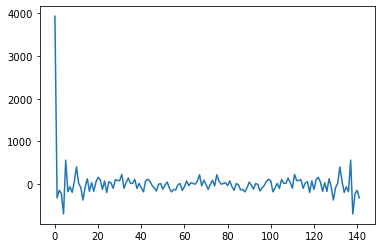

In [273]:
bad1 = np.fft.fft(total[total.Filename=='1AG6EOVQ.avi']['length'])
plt.plot(np.fft.fft(total[total.Filename=='1AG6EOVQ.avi']['length']))

In [268]:
std_grouped.describe()

,Size,Volume,x1,y1,x2,y2,length,frame,Degrees
count,106499.000000,106499.000000,106499.000000,106499.000000,106499.000000,106499.000000,106499.000000,106499.000000,106499.000000
mean,105.210199,9394.128804,2.655835,3.174915,2.414929,1.863240,4.374257,48.470391,3.430459
std,155.754990,7559.353971,1.560107,1.620230,1.381168,1.187057,1.976087,13.623783,2.286946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.669540,0.000000
25%,0.000000,4212.069420,1.752274,2.177380,1.604361,1.238238,3.095044,39.115214,2.412165
50%,0.000000,7179.855029,2.300532,2.850743,2.093254,1.593675,4.013690,48.352870,3.000249
75%,193.161529,12250.958592,3.085471,3.758555,2.804976,2.118694,5.182036,57.879185,3.833827
max,1704.889452,98596.092779,33.069737,29.771001,29.574509,33.595691,25.747221,72.312977,114.447540


In [269]:
std_grouped[(std_grouped['Volume']==0)].index

Index(['6S0RXZH7.avi', 'AJJ1AJJ3.avi', 'BMJSG6P7.avi', 'BN06959H.avi',
       'BN069716.avi', 'CW0WHBAV.avi', 'CW0WJ0VP.avi', 'D202G6R9.avi',
       'D2GFU1FZ.avi', 'E8AERLIS.avi'],
      dtype='object', name='Filename')

In [234]:
total[total.Filename=='1D7FV5C1.avi']

,Filename,Size,Volume,x1,y1,x2,y2,length,Problem,frame,Degrees
11082362,1D7FV5C1.avi,135,0.0,0,0,0,0,0.0,Size or points,0,0.0
11082363,1D7FV5C1.avi,154,0.0,0,0,0,0,0.0,Size or points,1,0.0
11082364,1D7FV5C1.avi,151,0.0,0,0,0,0,0.0,Size or points,2,0.0
11082365,1D7FV5C1.avi,107,0.0,0,0,0,0,0.0,Size or points,3,0.0
11082366,1D7FV5C1.avi,106,0.0,0,0,0,0,0.0,Size or points,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11082494,1D7FV5C1.avi,61,0.0,0,0,0,0,0.0,Size or points,132,0.0
11082495,1D7FV5C1.avi,57,0.0,0,0,0,0,0.0,Size or points,133,0.0
11082496,1D7FV5C1.avi,84,0.0,0,0,0,0,0.0,Size or points,134,0.0
11082497,1D7FV5C1.avi,51,0.0,0,0,0,0,0.0,Size or points,135,0.0


In [135]:
med_grouped.describe()

,Size,Volume,x1,y1,x2,y2,length,frame,Degrees
count,108450.000000,108450.000000,108450.000000,108450.000000,108450.000000,108450.000000,108450.000000,108450.000000,108450.000000
mean,1718.771540,30687.764147,69.224177,81.548621,57.526372,26.869267,56.521164,82.949511,-101.744779
std,810.362593,24731.781779,7.862476,12.512835,6.655009,7.393372,11.845701,24.019007,8.166878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-151.032339
25%,1119.000000,13873.519615,64.000000,71.000000,53.000000,22.000000,47.434165,67.000000,-106.389540
50%,1538.000000,23356.072382,69.000000,83.000000,58.000000,26.000000,55.708428,82.500000,-101.888658
75%,2158.000000,39645.074828,74.000000,91.000000,62.000000,32.000000,64.307850,99.500000,-97.236922
max,6788.000000,283012.411649,108.000000,111.000000,108.000000,80.000000,113.600176,124.500000,0.000000


In [86]:
sum(grouped.index==med_grouped.index)/len(med_grouped)

1.0

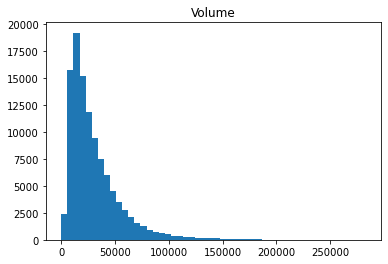

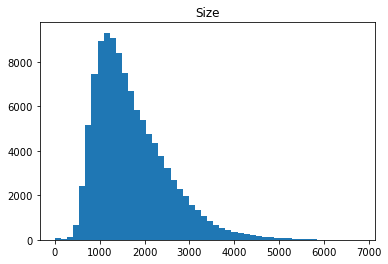

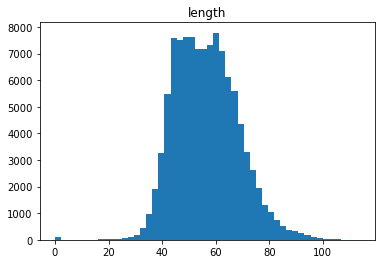

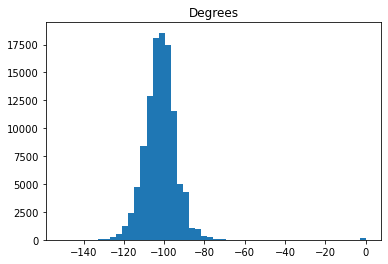

In [223]:

plt.hist(med_grouped['Volume'],bins=50)
plt.title("Volume")
plt.show()
plt.hist(med_grouped['Size'],bins=50)
plt.title("Size")
plt.show()
plt.hist(med_grouped['length'],bins=50)
plt.title("length")
plt.show()
plt.hist(med_grouped['Degrees'],bins=50)
plt.title("Degrees")
plt.show()

In [160]:
(grouped["Problem"]==0)['5B6E010O.avi']

True

In [194]:

def outside(series,q1=None,q3=None):
    if q1 is None:
        q1 = series.quantile(.25)
    if q3 is None:
        q3 = series.quantile(.75)
    return ~series.between(q1, q3, inclusive=True)
conditions = [(grouped["Size"]<32) | (grouped["Problem"]>0),outside(med_grouped['Size']),outside(med_grouped['Volume']),outside(med_grouped['length']),outside(med_grouped['Degrees'])]

In [195]:
len(med_grouped[conditions[0] & conditions[1] & conditions[2] & conditions[3]& conditions[4]])


707

(array([407., 553.,   0.,  11.,  51.,  43.,  30.,  10.,  11.,   3.]),
 array([   0. ,  567.8, 1135.6, 1703.4, 2271.2, 2839. , 3406.8, 3974.6,
        4542.4, 5110.2, 5678. ]),
 <a list of 10 Patch objects>)

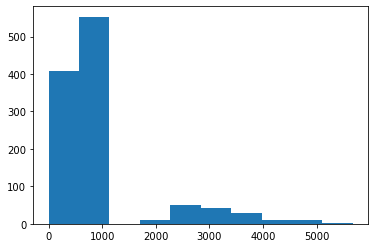

In [196]:
plt.hist(med_grouped[conditions[0] & conditions[1] & conditions[2] & conditions[3]]['Size'])

(array([963.,   9.,  69.,  40.,  20.,   8.,   6.,   2.,   1.,   1.]),
 array([     0.        ,  21273.33172651,  42546.66345301,  63819.99517952,
         85093.32690602, 106366.65863253, 127639.99035903, 148913.32208554,
        170186.65381204, 191459.98553855, 212733.31726505]),
 <a list of 10 Patch objects>)

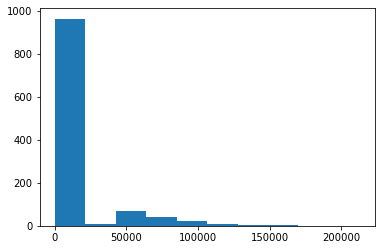

In [197]:
plt.hist(med_grouped[conditions[0] & conditions[1] & conditions[2] & conditions[3]]['Volume'])

(array([124.,  35., 112., 311., 380.,   0.,  13.,  75.,  50.,  19.]),
 array([ 0.        ,  9.61509218, 19.23018435, 28.84527653, 38.46036871,
        48.07546088, 57.69055306, 67.30564524, 76.92073741, 86.53582959,
        96.15092177]),
 <a list of 10 Patch objects>)

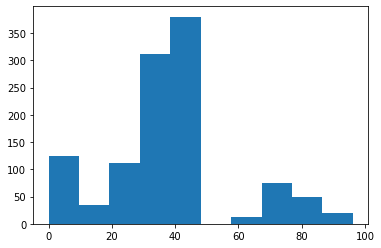

In [198]:
plt.hist(med_grouped[conditions[0] & conditions[1] & conditions[2] & conditions[3]]['length'])

In [199]:
#conditions = [~(grouped["Size"]<32) | ~(grouped["Problem"]>0),~outside(med_grouped['Size']),~outside(med_grouped['Volume']),~outside(med_grouped['length']),~outside(med_grouped['Degrees'])]

In [200]:
mask = conditions[0]
for i in conditions:
    mask = mask | i
print(sum(mask)/len(mask))

0.8310742277547257


In [201]:
len(mask)-sum(mask)

18320

In [202]:
mask['5B6E010O.avi']

False

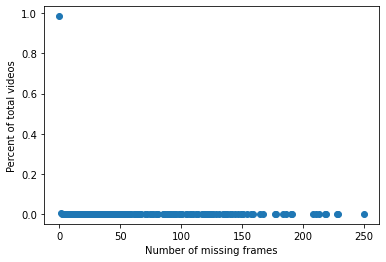

In [171]:
results = []
x = []
for i in range(0,1500):
    if sum(grouped['Problem']==i)>0:
        results.append(sum(grouped['Problem']==i)/len(grouped))
        x.append(i)
import numpy as np
plt.scatter(x,results)
plt.ylabel("Percent of total videos")
plt.xlabel("Number of missing frames")
print()

In [172]:
sum(grouped['Problem']==0)*100/len(grouped)

98.52005532503458

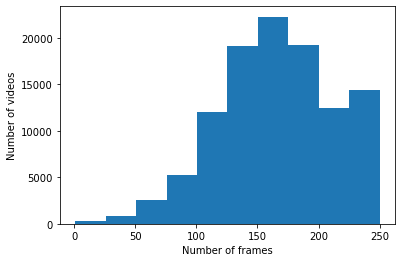

In [173]:
import numpy as np
plt.hist(grouped['frame'])
plt.ylabel("Number of videos")
plt.xlabel("Number of frames")
plt.show()

In [174]:
sum(grouped["frame"]<32)/len(grouped)

0.00318118948824343

In [175]:
grouped.index

Index(['1AFJUFVQ.avi', '1AG1LTSE.avi', '1AG6EOVQ.avi', '1AGCWGMH.avi',
       '1AGV8XHL.avi', '1AH0ALM3.avi', '1AH0SCXW.avi', '1AHC0WQG.avi',
       '1AW2TJWA.avi', '1AW2TU3F.avi',
       ...
       'FPLBUGZH.avi', 'FPLBUM29.avi', 'FPLBX3G4.avi', 'FPLBX471.avi',
       'FPLBZDX8.avi', 'FPLBZEPH.avi', 'FPLC33HR.avi', 'FPLC35KQ.avi',
       'FPLC3J05.avi', 'FPLC5Y4N.avi'],
      dtype='object', name='Filename', length=108450)

In [176]:
import numpy as np

In [203]:
planned_elimination = med_grouped[mask].index
greater_planned_elimation = grouped[grouped["Size"]<107].index # drop 10% smallest

In [204]:
print(sum(grouped["Size"]<32),sum(grouped["Problem"]>0),sum(grouped["Size"]<32)+sum(grouped["Problem"]>0))

345 1605 1950


In [205]:
len(planned_elimination)

90130

In [206]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

[ 24  53  90 124] [ 38  74 108]
3 4


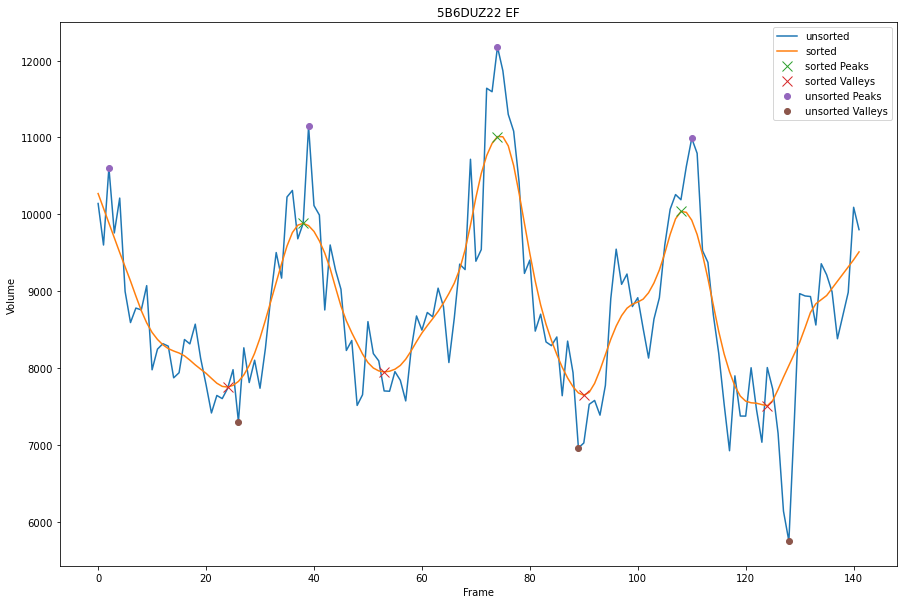

In [207]:
"""
use scipy signal finding to find local mins and maxes
smooth data
use scipy signal finding to find local mins and maxes
find ratio of local mins and maxes
(smoothed volume->(np array), EF predictions -> numpy array),(volume->(np array), EF predictions -> numpy array)
"""

def plot_vol(vol,title,frac=0.1):
    
    if len(vol)<32:
        return None
    plt.figure(figsize=(15,10))
    sort = lowess(vol,range(0,len(vol)),frac=frac,return_sorted=False)
    plt.plot(range(0,len(vol)),vol,label='unsorted')
    plt.plot(range(0,len(vol)),sort,label='sorted')
    sort_peaks,_ = find_peaks(sort)
    sort_valley,_ = find_peaks(-1*sort)
    print(sort_valley,sort_peaks)
    plt.plot(sort_peaks, sort[sort_peaks], "x",label="sorted Peaks",markersize=10)
    plt.plot(sort_valley, sort[sort_valley], "x",label="sorted Valleys",markersize=10)
    unsorted_peaks,_ = find_peaks(vol,distance=32)
    unsorted_valley,_ = find_peaks(-1*vol,distance=32)
    plt.plot(unsorted_peaks, vol[unsorted_peaks], "o",label="unsorted Peaks")
    plt.plot(unsorted_valley, vol[unsorted_valley], "o",label="unsorted Valleys")
    print(len(sort_peaks),len(unsorted_peaks))
    plt.xlabel("Frame")
    plt.ylabel("Volume")
    plt.title(title)
    plt.legend()
    plt.show()
plot_vol(total[total.Filename=='5B6DUZ22.avi']["Volume"].reset_index(drop=True),"5B6DUZ22 EF")

[[ 2.19430574e+03 -2.14408301e-03 -4.54708546e+01 -2.68231408e+01]
 [-2.14408301e-03  1.22015451e-06  3.01944162e-02 -6.50815175e-03]
 [-4.54708546e+01  3.01944162e-02  9.40252807e+02 -1.56899010e+02]
 [-2.68231408e+01 -6.50815175e-03 -1.56899010e+02  1.14507020e+03]]


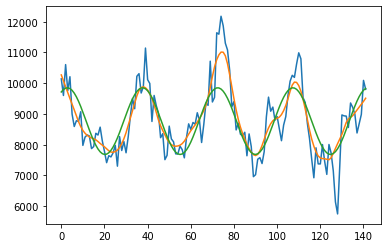

In [208]:
from scipy.optimize import curve_fit

def sinfunc(x, a, b, c, d):
    return a * np.sin(b * (x - np.radians(c)))+d

def sin_regress(arr):
    smooth = lowess(arr,range(0,len(arr)),frac=0.1,return_sorted=False)
    plt.plot(range(0,len(arr)),arr,label='unsmoothed')
    plt.plot(range(0,len(arr)),smooth,label='smoothed')
    d = np.mean(arr)
    c = 0
    b = np.pi/16
    a = (np.max(arr)-np.min(arr))/2
    results,matrix = curve_fit(sinfunc,range(0,len(arr)),smooth,p0=[a,b,c,d])
    print(matrix)
    a,b,c,d = results
    plt.plot(np.arange(0,len(arr)),sinfunc(np.arange(0,len(arr)),a,b,c,d))
sin_regress(total[total.Filename=='5B6DUZ22.avi']["Volume"].reset_index(drop=True))

In [209]:
def EF_estimator(vol):
    
    if len(vol)<32:
        return None
    smoothed = lowess(vol,range(0,len(vol)),frac=0.1,return_sorted=False)
    sort_peaks,_ = find_peaks(smoothed)
    sort_valley,_ = find_peaks(-1*smoothed)
    index = 0
    EFs = []
    for max_vol in sort_peaks:
        while index<len(sort_valley)-1 and sort_valley[index]<max_vol:
            index+=1
        low = smoothed[sort_valley[index]]
        high = smoothed[max_vol]
        EFs.append((1-low/high)*100)
    return EFs

EF_estimator(total[total.Filename=='5B6DUZ22.avi']["Volume"].reset_index(drop=True))

[19.561949262441736, 30.561984820446774, 25.184769529929298]

In [218]:
valid_options = mask[mask==False].index

In [219]:
ef_est = []
planned_count = 0
extended = 0

for filename in tqdm(valid_options):
    if filename in planned_elimination:
        planned_count+=1
    elif filename in greater_planned_elimation:
        print(filename)
        extended +=1
    else:
        ef = EF_estimator(total[total.Filename==filename]["length"].reset_index(drop=True))
        ef_est.append(np.mean(ef))
plt.hist(estimations)

  0%|                                                                              | 6/18320 [00:03<3:03:00,  1.67it/s]

1AWEVVXP.avi
1AWPWFXJ.avi


  0%|                                                                             | 25/18320 [00:15<3:08:37,  1.62it/s]

1AXEMU50.avi


  0%|▏                                                                            | 48/18320 [00:32<3:39:54,  1.38it/s]

1BCSG83O.avi


  0%|▎                                                                            | 67/18320 [00:44<3:06:22,  1.63it/s]

1BDG5G6K.avi


  0%|▎                                                                            | 78/18320 [00:51<3:04:55,  1.64it/s]

1BDM98BN.avi


  0%|▎                                                                            | 81/18320 [00:53<2:49:38,  1.79it/s]

1BDMBZTE.avi


  0%|▎                                                                            | 85/18320 [00:54<2:31:44,  2.00it/s]

1BDRVAZ8.avi
1BDRYUUV.avi


  0%|▎                                                                            | 88/18320 [00:56<2:32:43,  1.99it/s]

1BDS1P4C.avi


  1%|▍                                                                           | 101/18320 [01:05<3:08:50,  1.61it/s]

1BEFMV6Y.avi


  1%|▊                                                                           | 196/18320 [02:13<3:09:01,  1.60it/s]

1CA6XE2H.avi


  1%|▊                                                                           | 202/18320 [02:17<3:01:11,  1.67it/s]

1CACXGCV.avi


  1%|▊                                                                           | 207/18320 [02:20<2:58:15,  1.69it/s]

1CAIRUO2.avi


  1%|▉                                                                           | 216/18320 [02:25<2:53:50,  1.74it/s]

1CAUAXKF.avi
1CB0K4XF.avi
1CB0KGW6.avi
1CB0LWL5.avi


  1%|▉                                                                           | 221/18320 [02:27<2:35:23,  1.94it/s]

1CB0OHG0.avi


  1%|▉                                                                           | 228/18320 [02:31<2:59:15,  1.68it/s]

1CB0VMHG.avi


  1%|█                                                                           | 262/18320 [02:55<3:06:17,  1.62it/s]

1CQKIDGX.avi
1CQKKEXQ.avi


  2%|█▏                                                                          | 279/18320 [03:06<3:06:56,  1.61it/s]

1CQWIUZE.avi


  2%|█▎                                                                          | 312/18320 [03:28<2:46:54,  1.80it/s]

1CRKCV8D.avi
1CRKDE91.avi
1CRPUIYJ.avi
1CRQ0ITJ.avi


  2%|█▍                                                                          | 339/18320 [03:46<2:55:43,  1.71it/s]

1D72NBTU.avi
1D73WAKZ.avi


  2%|█▌                                                                          | 386/18320 [04:20<3:04:36,  1.62it/s]

1D83BDBR.avi


  2%|█▋                                                                          | 407/18320 [04:35<3:05:54,  1.61it/s]

1D89MQLW.avi


  2%|█▋                                                                          | 412/18320 [04:38<2:57:49,  1.68it/s]

1DNB2EAW.avi


  2%|█▋                                                                          | 419/18320 [04:42<3:00:34,  1.65it/s]

1DNMZ4YS.avi


  2%|█▊                                                                          | 432/18320 [04:51<3:04:26,  1.62it/s]

1DNYCF8B.avi


  2%|█▉                                                                          | 455/18320 [05:07<3:07:30,  1.59it/s]

1DOMOO5S.avi


  3%|█▉                                                                          | 465/18320 [05:14<3:12:00,  1.55it/s]

1DON436F.avi


  3%|█▉                                                                          | 471/18320 [05:18<3:05:15,  1.61it/s]

1DOSVG7Z.avi


  3%|█▉                                                                          | 474/18320 [05:19<2:51:25,  1.74it/s]

1DOT00KW.avi


  3%|██                                                                          | 488/18320 [05:29<3:06:25,  1.59it/s]

1DP4UNGT.avi
1DP4W8E4.avi


  3%|██                                                                          | 492/18320 [05:30<2:26:42,  2.03it/s]

1DP4YRMC.avi


  3%|██                                                                          | 496/18320 [05:32<2:40:40,  1.85it/s]

1E3US29L.avi


  3%|██▏                                                                         | 524/18320 [05:54<3:20:37,  1.48it/s]


KeyboardInterrupt: 

In [25]:
print('5B6D365B.avi' in planned_elimination, '5BMFKMDP.avi' in planned_elimination)

True True


Text(0.5, 1.0, 'First 574 Files')

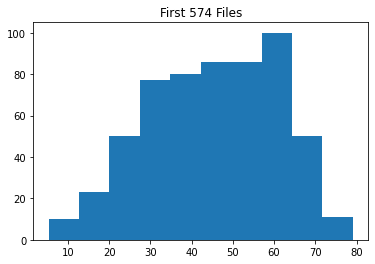

In [119]:
plt.hist(estimations)
plt.title("First 574 Files")

In [122]:
sum(np.array(estimations)<35)/len(np.array(estimations))

<ipython-input-122-742eb0d0478a>:1: RuntimeWarning: invalid value encountered in less
  sum(np.array(estimations)<35)/len(np.array(estimations))


0.28397212543554007

[ 16  53  87 124] [ 37  70 106]
3 3


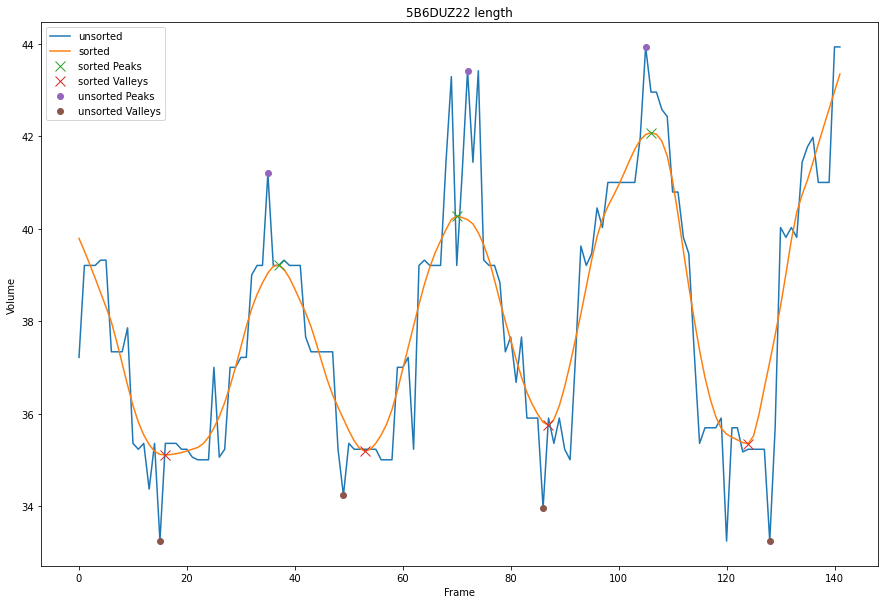

[10.276762968687914, 11.224184221099865, 15.988796508372982]

In [39]:
plot_vol(total[total.Filename=='5B6DUZ22.avi']["length"].reset_index(drop=True),"5B6DUZ22 length")
EF_estimator(total[total.Filename=='5B6DUZ22.avi']["length"].reset_index(drop=True))

In [64]:
strain_est = []
planned_count = 0
extended = 0
for filename in tqdm(total.Filename.unique()):
    if filename in planned_elimination:
        print(filename)
        planned_count+=1
    elif filename in greater_planned_elimation:
        extended +=1
    else:
        ef = EF_estimator(total[total.Filename==filename]["length"].reset_index(drop=True))
        strain_est.append(np.mean(ef))
plt.hist(strain_est)

  0%|                                                                            | 2/108450 [00:00<11:05:10,  2.72it/s]

5B6D365B.avi


  0%|                                                                           | 51/108450 [00:31<18:14:20,  1.65it/s]

5B6EB39H.avi


  0%|                                                                          | 136/108450 [01:31<15:43:05,  1.91it/s]

5B6W2WJP.avi


  0%|                                                                          | 156/108450 [01:45<18:58:56,  1.58it/s]

5BLLMUVR.avi


  0%|▏                                                                         | 231/108450 [02:35<18:52:45,  1.59it/s]

5BMFFPPB.avi


  0%|▏                                                                         | 250/108450 [02:48<19:01:08,  1.58it/s]

5BMFKC81.avi
5BMFKMDP.avi


  0%|▏                                                                         | 364/108450 [04:04<18:16:39,  1.64it/s]

5BMRH24S.avi


  0%|▎                                                                         | 404/108450 [04:33<20:17:26,  1.48it/s]


KeyboardInterrupt: 